In [474]:
# https://www.kaggle.com/c/trackml-particle-identification/discussion/57643
import pandas as pd
import numpy as np
import os

from scipy.optimize import least_squares
from sklearn.preprocessing import StandardScaler
import hdbscan
from scipy import stats
from sklearn.neighbors import KDTree
from tqdm import tqdm
from sklearn.cluster import DBSCAN

from trackml.dataset import load_event, load_dataset
from trackml.score import score_event

import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

pd.set_option('display.max_columns', None)
%matplotlib inline

In [20]:
def helix_estimate_param_from_track(xyz):
    def residuals_xy(param, x, y):
        x0,y0 = param
        r = np.sqrt((x-x0)**2 + (y-y0)**2)
        d = r - r.mean()
        return d
    
    def residuals_z(param, r, z):
        m2,m1,m0 = param
        zz = m2*r**2 + m1*r + m0
        d = z - zz
        return d 
    
    x = xyz[:,0]
    y = xyz[:,1]
    z = xyz[:,2]
    
    param0 = (x.mean(),y.mean())
    res_lsq = least_squares(residuals_xy, param0, loss='soft_l1', f_scale=1.0, args=(x,y))
    x0,y0 = res_lsq.x
    r0 = np.sqrt((x-x0)**2 + (y-y0)**2).mean()
    r = np.sqrt(x**2 + y**2)
    m2,m1,m0 = np.polyfit(r,z,2)
    
    param = x0,y0,r0,m2,m1,m0
    return param

def helix_make_search_theta(xyz, param, S=2.5):
    x0,y0,r0,m2,m1,m0 = param
    theta0 = np.arctan2(y0,x0)
    xyz = xyz[np.argsort(np.fabs(xyz[:,2]))]
    yy = xyz[:,1]-y0
    xx = xyz[:,0] - x0
    x = xx*np.cos(theta0) - yy*np.sin(-theta0)
    y = xx*np.sin(-theta0) + yy*np.cos(-theta0)
    theta = np.arctan2(y,-x)
    theta_min = 0
    theta_max = theta[-1]
    theta_num = S * len(xyz) * 50
    return np.linspace(theta_min, theta_max, theta_num)

def helix_generate_track_from_param(param, q=+1, theta=np.linspace(0, 2*np.pi, 360)):
    x0,y0,r0,m2,m1,m0 = param
    theta0 = np.arctan2(y0,x0)
    xx = -r0*np.cos(theta)
    yy = r0*np.sin(theta)
    x = xx*np.cos(theta0) - yy*np.sin(theta0) + x0
    y = xx*np.sin(theta0) + yy*np.cos(theta0) + y0
    
    r = np.sqrt(x**2 + y**2)
    z = m2*r**2 + m1*r 
    
    xyz = np.column_stack([x,y,z])
    
    return xyz

In [ ]:
def extend(submission,hits):
#     df = submission.merge(hits,  on=['hit_id'], how='left')
    df = submission.append(hits)
#     print(df.head())
    df = df.assign(d = np.sqrt( df.x**2 + df.y**2 + df.z**2 ))
    df = df.assign(r = np.sqrt( df.x**2 + df.y**2))
    df = df.assign(arctan2 = np.arctan2(df.z, df.r))

    for angle in range(-180,180,1):

        print ('\r %f'%angle, end='',flush=True)
        #df1 = df.loc[(df.arctan2>(angle-0.5)/180*np.pi) & (df.arctan2<(angle+0.5)/180*np.pi)]
        df1 = df.loc[(df.arctan2>(angle-1.0)/180*np.pi) & (df.arctan2<(angle+1.0)/180*np.pi)]

        min_num_neighbours = len(df1)
        if min_num_neighbours<4: continue

        hit_ids = df1.hit_id.values
        x,y,z = df1.as_matrix(columns=['x', 'y', 'z']).T
        r  = (x**2 + y**2)**0.5
        r  = r/1000
        a  = np.arctan2(y,x)
        tree = KDTree(np.column_stack([a,r]), metric='euclidean')

        track_ids = list(df1.track_id.unique())
        num_track_ids = len(track_ids)
        min_length=3

        for i in range(num_track_ids):
            p = track_ids[i]
            if p==0: continue

            idx = np.where(df1.track_id==p)[0]
            if len(idx)<min_length: continue

            if angle>0:
                idx = idx[np.argsort( z[idx])]
            else:
                idx = idx[np.argsort(-z[idx])]


            ## start and end points  ##
            idx0,idx1 = idx[0],idx[-1]
            a0 = a[idx0]
            a1 = a[idx1]
            r0 = r[idx0]
            r1 = r[idx1]

            da0 = a[idx[1]] - a[idx[0]]  #direction
            dr0 = r[idx[1]] - r[idx[0]]
            direction0 = np.arctan2(dr0,da0) 

            da1 = a[idx[-1]] - a[idx[-2]]
            dr1 = r[idx[-1]] - r[idx[-2]]
            direction1 = np.arctan2(dr1,da1) 


            ## extend start point
            ns = tree.query([[a0,r0]], k=min(20,min_num_neighbours), return_distance=False)
            ns = np.concatenate(ns)
            direction = np.arctan2(r0-r[ns],a0-a[ns])
            ns = ns[(r0-r[ns]>0.01) &(np.fabs(direction-direction0)<0.04)]

            for n in ns:
                df.loc[ df.hit_id==hit_ids[n],'track_id' ] = p 

            ## extend end point
            ns = tree.query([[a1,r1]], k=min(20,min_num_neighbours), return_distance=False)
            ns = np.concatenate(ns)

            direction = np.arctan2(r[ns]-r1,a[ns]-a1)
            ns = ns[(r[ns]-r1>0.01) &(np.fabs(direction-direction1)<0.04)] 

            for n in ns:
                df.loc[ df.hit_id==hit_ids[n],'track_id' ] = p
    #print ('\r')
    df = df[['particle_id', 'weight', 'event_id', 'hit_id', 'track_id']]
    return df

In [301]:
def extend_my0(submission,hits):
#     df = submission.merge(hits,  on=['hit_id'], how='left')
    df = submission.append(hits)
    df = df.assign(d = np.sqrt( df.x**2 + df.y**2 + df.z**2 ))
    df = df.assign(r = np.sqrt( df.x**2 + df.y**2))
    df = df.assign(arctan2 = np.arctan2(df.z, df.r))

    for angle in range(-180,180,1):

        print ('\r %f'%angle, end='',flush=True)
        #df1 = df.loc[(df.arctan2>(angle-0.5)/180*np.pi) & (df.arctan2<(angle+0.5)/180*np.pi)]
        df1 = df.loc[(df.arctan2>(angle-1.0)/180*np.pi) & (df.arctan2<(angle+1.0)/180*np.pi)]

        min_num_neighbours = len(df1)
        if min_num_neighbours<4: continue

        hit_ids = df1.hit_id.values
        x,y,z = df1.as_matrix(columns=['x', 'y', 'z']).T
        r  = (x**2 + y**2)**0.5
        r  = r/1000
        a  = np.arctan2(y,x)
        tree = KDTree(np.column_stack([a,r]), metric='euclidean')

        track_ids = list(df1.track_id.unique())
        num_track_ids = len(track_ids)
        min_length=3

        for i in range(num_track_ids):
            p = track_ids[i]
            if p==0: continue

            idx = np.where(df1.track_id==p)[0]
            if len(idx)<min_length: continue

            
            if angle>0:
                idx = idx[np.argsort( z[idx])]
            else:
                idx = idx[np.argsort(-z[idx])]


            print(idx, angle)
            ## start and end points  ##
            idx0,idx1 = idx[0],idx[-1]
            a0 = a[idx0]
            a1 = a[idx1]
            r0 = r[idx0]
            r1 = r[idx1]

            da0 = a[idx[1]] - a[idx[0]]  #direction
            dr0 = r[idx[1]] - r[idx[0]]
            direction0 = np.arctan2(dr0,da0) 

            da1 = a[idx[-1]] - a[idx[-2]]
            dr1 = r[idx[-1]] - r[idx[-2]]
            direction1 = np.arctan2(dr1,da1) 


            ## extend start point
            ns = tree.query([[a0,r0]], k=min(20,min_num_neighbours), return_distance=False)
            ns = np.concatenate(ns)
            direction = np.arctan2(r0-r[ns],a0-a[ns])
            ns = ns[(r0-r[ns]>0.01) &(np.fabs(direction-direction0)<0.04)]

            for n in ns:
                df.loc[ df.hit_id==hit_ids[n],'track_id' ] = p 

            ## extend end point
            ns = tree.query([[a1,r1]], k=min(20,min_num_neighbours), return_distance=False)
            ns = np.concatenate(ns)

            direction = np.arctan2(r[ns]-r1,a[ns]-a1)
            ns = ns[(r[ns]-r1>0.01) &(np.fabs(direction-direction1)<0.04)] 

            for n in ns:
                df.loc[ df.hit_id==hit_ids[n],'track_id' ] = p
#print ('\r')
    df = df[['particle_id', 'weight', 'event_id', 'hit_id', 'track_id']]
    return df

In [581]:
path_to_train = "../data/train"
p = 297237712845406208
for event_id, hits, cells, particles, truth in load_dataset(path_to_train, nevents=1):
    truth = pd.merge(truth, particles, how='left', on='particle_id')
    hits = pd.merge(hits, truth, how='left', on='hit_id')
        
    hits = hits.fillna(0)

    print(hits.head())
    t = hits.loc[hits.particle_id == p].as_matrix(columns=['x','y','z'])
    param = helix_estimate_param_from_track(t)
    theta = helix_make_search_theta(t, param, S =1)
    helix = helix_generate_track_from_param(param, theta=theta)
    
    

   hit_id          x         y       z  volume_id  layer_id  module_id  \
0       1 -64.409897 -7.163700 -1502.5          7         2          1   
1       2 -55.336102  0.635342 -1502.5          7         2          1   
2       3 -83.830498 -1.143010 -1502.5          7         2          1   
3       4 -96.109100 -8.241030 -1502.5          7         2          1   
4       5 -62.673599 -9.371200 -1502.5          7         2          1   

          particle_id         tx        ty      tz            tpx  \
0                   0 -64.411598 -7.164120 -1502.5  250710.000000   
1   22525763437723648 -55.338501  0.630805 -1502.5      -0.570605   
2                   0 -83.828003 -1.145580 -1502.5  626295.000000   
3  297237712845406208 -96.122902 -8.230360 -1502.5      -0.225235   
4  418835796137607168 -62.659401 -9.375040 -1502.5      -0.281806   

             tpy           tpz    weight        vx        vy       vz  \
0 -149908.000000 -956385.00000  0.000000  0.000000  0.000000  0.000

In [22]:
helix

array([[  -44.99636551,    -1.61411873,  -672.84006164],
       [  -44.99372605,    -1.69379883,  -672.84451083],
       [  -44.9915238 ,    -1.77349222,  -672.85785811],
       ...,
       [  -73.82344547,    -4.68386193, -1126.16141127],
       [  -73.83721428,    -4.6053361 , -1126.30187637],
       [  -73.85055205,    -4.52673592, -1126.43676457]])

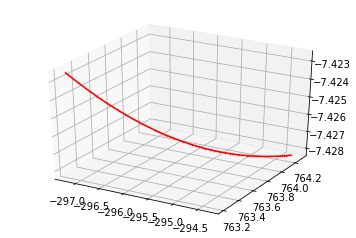

In [578]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(helix[:,0], helix[:,1], helix[:,2], marker='.',color=[1,0,0],markersize=1 )
# ax.plot(helix[:,0], helix[:,1], helix[:,2], marker='.',color=[1,0,0],markersize=1 )
plt.show()

In [43]:
particles_list = list(set(hits.particle_id.values))

In [44]:
len(particles_list)

10566

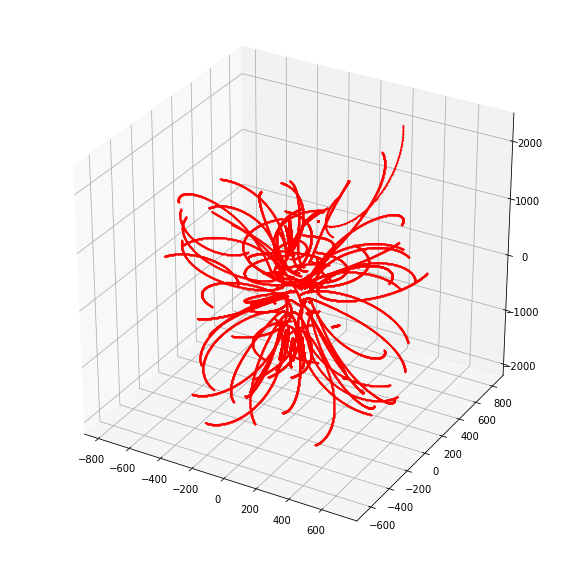

In [50]:
np.random.seed(123)
for event_id, hits, cells, particles, truth in load_dataset(path_to_train, nevents=1):
    truth = pd.merge(truth, particles, how='left', on='particle_id')
    hits = pd.merge(hits, truth, how='left', on='hit_id')
        
    hits = hits.fillna(0)

#     print(hits.head())
    particles_list = list(set(hits.particle_id.values))
    particles_s = np.random.choice(particles_list, 100)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    for p in particles_s:
        t = hits.loc[hits.particle_id == p].as_matrix(columns=['x','y','z'])
        param = helix_estimate_param_from_track(t)
        theta = helix_make_search_theta(t, param, S =1)
        helix = helix_generate_track_from_param(param, theta=theta)
        ax.plot(helix[:,0], helix[:,1], helix[:,2], marker='.',color=[1,0,0],markersize=1 )
    plt.show()

In [73]:
df = hits

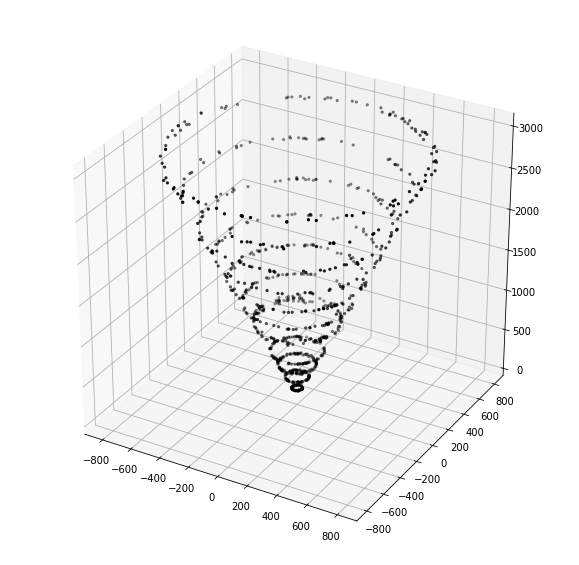

In [74]:
df = df.assign(d =np.sqrt(df.x**2 + df.y**2 + df.z**2))
df = df.assign(r = np.sqrt(df.x**2 + df.y ** 2))
df = df.assign(arctan2 = np.arctan2(df.z, df.r))

df = df.loc[(df.arctan2 > (75-0.5)/180.*np.pi) & (df.arctan2 < (75+0.5)/180.*np.pi)]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['x'], df['y'], df['z'], marker='.', color=[0,0,0])
plt.show()

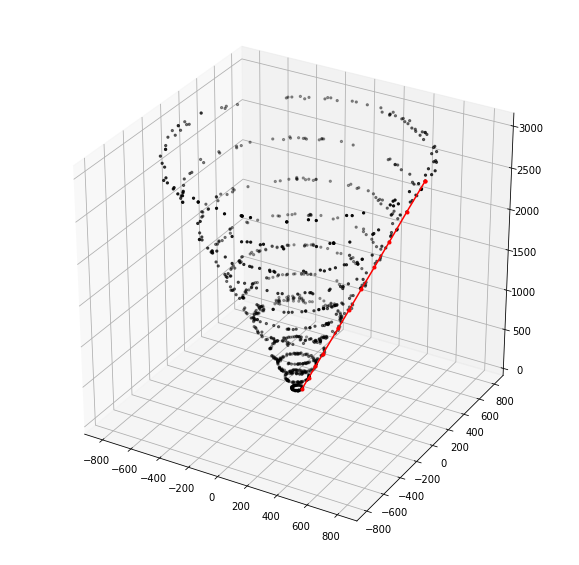

In [88]:
df = df.assign(d =np.sqrt(df.x**2 + df.y**2 + df.z**2))
df = df.assign(r = np.sqrt(df.x**2 + df.y ** 2))
df = df.assign(arctan2 = np.arctan2(df.z, df.r))
df = df.assign(arctan2_deg = np.degrees(np.arctan2(df.z, df.r)))

df = df.loc[(df.arctan2_deg > 75-0.5) & (df.arctan2_deg < 75+0.5)]
p = 18019964787097600
df1 = df[df.particle_id == p]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['x'], df['y'], df['z'], marker='.', color=[0,0,0])
ax.plot(df1['x'], df1['y'], df1['z'], marker='.', color=[1,0,0])
plt.show()

In [87]:
df1

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,...,vz,px,py,pz,q,nhits,d,r,arctan2,arctan2_deg
102117,102118,81.432602,568.86499,2145.5,14,8,124,18015704179539968,81.484497,569.049988,...,3.7448,-0.13686,0.133635,0.615743,1.0,10.0,2221.127686,574.66394,1.309093,75.005501


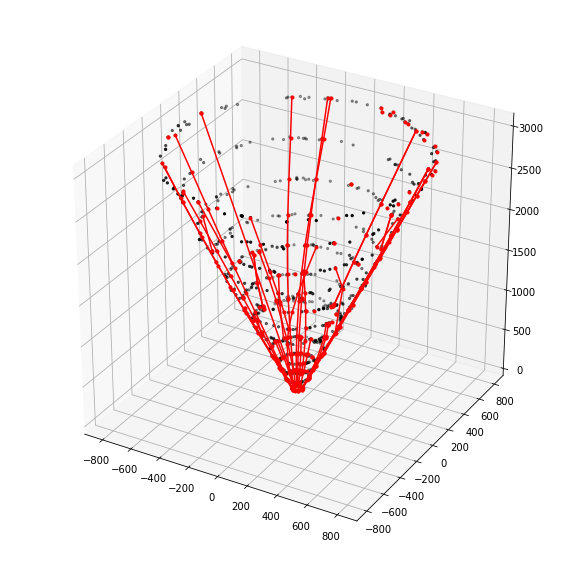

In [97]:
df = df.assign(d =np.sqrt(df.x**2 + df.y**2 + df.z**2))
df = df.assign(r = np.sqrt(df.x**2 + df.y ** 2))
df = df.assign(arctan2 = np.arctan2(df.z, df.r))
df = df.assign(arctan2_deg = np.degrees(np.arctan2(df.z, df.r)))

df = df.loc[(df.arctan2_deg > 75-0.5) & (df.arctan2_deg < 75+0.5)]
particles_list = list(set(df.particle_id.values))
part = np.random.choice(particles_list, 100)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['x'], df['y'], df['z'], marker='.', color=[0,0,0])
for p in part:
    df1 = df[df.particle_id == p]
    ax.plot(df1['x'], df1['y'], df1['z'], marker='.', color=[1,0,0])
plt.show()

In [96]:
print(df.particle_id.nunique())

251


In [582]:
#  most imp phi, then r
scl = StandardScaler()

# rz_scales=[0.65, 0.965, 1.528]
rz_scales=[1., 1., 1.]

x = hits.x.values
y = hits.y.values
z = hits.z.values
hits['event_id'] = 1000

hits['rho'] = np.sqrt(x**2 + y**2 + z**2)
hits['r'] = np.sqrt(x**2 + y**2)

hits['x2'] = hits['x']/hits['rho']
hits['y2'] = hits['y']/hits['rho']
hits['z2'] = hits['z']/hits['r']

hits['x2'] = hits['x2'] * rz_scales[0]
hits['y2'] = hits['y2'] * rz_scales[1]
hits['z2'] = hits['z2'] * rz_scales[2]


x2 = hits.x2.values
y2 = hits.y2.values
z2 = hits.z2.values

hits['r2'] = np.sqrt(x2**2 + y2**2)
hits['phi'] = np.arctan2(hits['y'], hits['x'])
hits['phi_deg'] = np.degrees(np.arctan2(hits['y'], hits['x']))
hits['phi2'] = np.arctan2(hits['y2'], hits['x2'])
hits['phi2_deg'] = np.degrees(np.arctan2(hits['y2'], hits['x2']))

hits['theta'] = np.arctan2(hits['r'], hits['z'])
hits['theta_1'] = np.arctan2(hits['r2'], hits['z2'])

phi = hits['phi'].values
theta = hits['theta'].values
rho = hits['rho'].values
r = hits['r'].values
hits['tan_dip'] = phi/theta
hits['tan_dip1'] = phi/z2
hits['z2_1'] = 1/z2
hits['z2_2'] = phi/z2 + 1/z2
# hits['dip'] = np.degrees(np.arctan2(hits['phi'], hits['z2']))
hits['dip_angle'] = np.arctan2(z2, (np.sqrt(x2**2 +y2**2)) * np.arccos(x2/np.sqrt(x2**2 + y2**2)))
scores = []
hits1 = hits[(hits.phi_deg < 75+0.5) & (hits.phi_deg >  75-0.5)]
for m in ['manhattan']: #Tuning/Grid Search
    print(m)
    try:
        dbscan = DBSCAN(eps=0.0038, min_samples=1,metric='manhattan',n_jobs=8)
        
#             cl = Clusterer2()
        hits1['track_id'] = dbscan.fit_predict(scl.fit_transform(hits1[['r2', 'theta_1', 'dip_angle', 'z2', 'z2_1', 'z2_2']].values))
#             hits['track_id'] = cl.predict(hits)
        score = score_event(hits1, hits1[['event_id','hit_id','track_id']])
        print(m, len(hits1['particle_id'].unique()), len(hits1['track_id'].unique()), score)
        scores.append([score, m])
    except e:
        print("ERROR:", e)
#         break #Remove to test all
#     break #Remove to test more samples
print(sorted(scores, reverse=True))


manhattan
manhattan 190 244 0.7788785689974714
[[0.7788785689974714, 'manhattan']]


In [198]:
#  most imp phi, then r
scl = StandardScaler()

# rz_scales=[0.65, 0.965, 1.528]
rz_scales=[1., 1., 1.]

x = hits.x.values
y = hits.y.values
z = hits.z.values
hits['event_id'] = 1000

hits['rho'] = np.sqrt(x**2 + y**2 + z**2)
hits['r'] = np.sqrt(x**2 + y**2)

hits['x2'] = hits['x']/hits['rho']
hits['y2'] = hits['y']/hits['rho']
hits['z2'] = hits['z']/hits['r']

hits['x2'] = hits['x2'] * rz_scales[0]
hits['y2'] = hits['y2'] * rz_scales[1]
hits['z2'] = hits['z2'] * rz_scales[2]


x2 = hits.x2.values
y2 = hits.y2.values
z2 = hits.z2.values

hits['r2'] = np.sqrt(x2**2 + y2**2)
hits['phi'] = np.arctan2(hits['y'], hits['x'])
hits['phi_deg'] = np.degrees(np.arctan2(hits['y'], hits['x']))
hits['phi2'] = np.arctan2(hits['y2'], hits['x2'])
hits['phi2_deg'] = np.degrees(np.arctan2(hits['y2'], hits['x2']))

hits['theta'] = np.arctan2(hits['r'], hits['z'])
hits['theta_1'] = np.arctan2(hits['r2'], hits['z2'])

phi = hits['phi'].values
theta = hits['theta'].values
rho = hits['rho'].values
r = hits['r'].values
hits['tan_dip'] = phi/theta
hits['tan_dip1'] = phi/z2
hits['z2_1'] = 1/z2
hits['z2_2'] = phi/z2 + 1/z2
# hits['dip'] = np.degrees(np.arctan2(hits['phi'], hits['z2']))
hits['dip_angle'] = np.arctan2(z2, (np.sqrt(x2**2 +y2**2)) * np.arccos(x2/np.sqrt(x2**2 + y2**2)))
scores = []

hits1 = hits[(hits.phi_deg < 75+0.5) & (hits.phi_deg >  75-0.5)]
for m in ['manhattan']: #Tuning/Grid Search
    print(m)
    try:
        dbscan = DBSCAN(eps=0.0038, min_samples=1,metric='manhattan',n_jobs=8)
        
#             cl = Clusterer2()
        hits1['track_id'] = dbscan.fit_predict(scl.fit_transform(hits1[['r2', 'theta_1', 'dip_angle', 'z2', 'z2_1', 'z2_2']].values))
#             hits['track_id'] = cl.predict(hits)
        score = score_event(hits1, hits1[['event_id','hit_id','track_id']])
        print(m, len(hits1['particle_id'].unique()), len(hits1['track_id'].unique()), score)
        scores.append([score, m])
    except e:
        print("ERROR:", e)
#         break #Remove to test all
#     break #Remove to test more samples
print(sorted(scores, reverse=True))


manhattan
manhattan 190 244 0.7788785689974714
[[0.7788785689974714, 'manhattan']]


In [143]:
np.max(hits.phi_deg)

179.99837

In [144]:
np.min(hits.phi_deg)

-179.99886

In [145]:
np.linspace(-180, 180, 20)

array([-180.        , -161.05263158, -142.10526316, -123.15789474,
       -104.21052632,  -85.26315789,  -66.31578947,  -47.36842105,
        -28.42105263,   -9.47368421,    9.47368421,   28.42105263,
         47.36842105,   66.31578947,   85.26315789,  104.21052632,
        123.15789474,  142.10526316,  161.05263158,  180.        ])

10


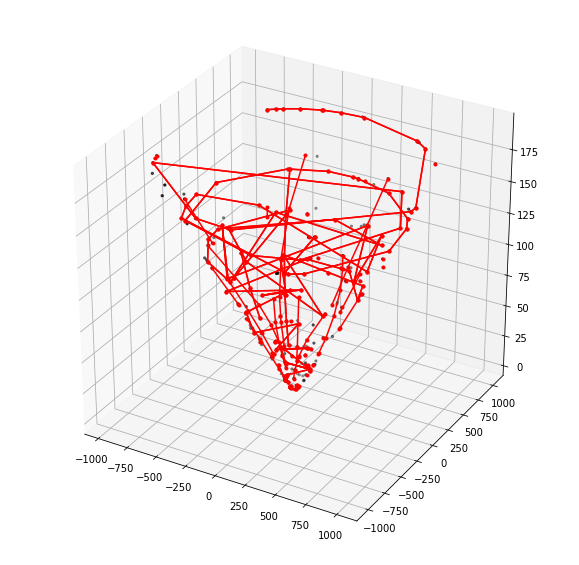

In [216]:
df = hits
df = df.assign(d =np.sqrt(df.x**2 + df.y**2 + df.z**2))
df = df.assign(r = np.sqrt(df.x**2 + df.y ** 2))
df = df.assign(arctan2 = np.arctan2(df.z, df.r))
df = df.assign(arctan2_deg = np.degrees(np.arctan2(df.z, df.r)))

for angle in [10]:
    print(angle)
    df = df.loc[(df.arctan2_deg > angle-0.5) & (df.arctan2_deg < angle+0.5)]
    particles_list = list(set(df.particle_id.values))
    if len(particles_list) ==0:
        continue
    part = np.random.choice(particles_list, 100)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df['x'], df['y'], df['z'], marker='.', color=[0,0,0])
    for p in part:
        df1 = df[df.particle_id == p]
        ax.plot(df1['x'], df1['y'], df1['z'], marker='.', color=[1,0,0])
    plt.show()

(array([12707., 11719., 11852., 11603., 12061., 11798., 12288., 12454.,
        12540., 11917.]),
 array([-1.79998856e+02, -1.43999133e+02, -1.07999411e+02, -7.19996887e+01,
        -3.59999664e+01, -2.44140625e-04,  3.59994781e+01,  7.19992004e+01,
         1.07998923e+02,  1.43998645e+02,  1.79998367e+02]),
 <a list of 10 Patch objects>)

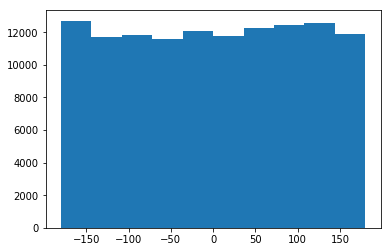

In [156]:
plt.hist(hits.phi_deg)

In [161]:
hits.shape

(120939, 41)

In [176]:
hits2 = hits
tot = 0
for angle in np.linspace(-180, 180, 1000):
    df = hits2
    df = df.assign(d =np.sqrt(df.x**2 + df.y**2 + df.z**2))
    df = df.assign(r = np.sqrt(df.x**2 + df.y ** 2))
    df = df.assign(arctan2 = np.arctan2(df.z, df.r))
    df = df.assign(arctan2_deg = np.degrees(np.arctan2(df.z, df.r)))
    df = df.loc[(df.arctan2_deg > angle-0.5) & (df.arctan2_deg < angle+0.5)]
    particles_list = list(set(df.particle_id.values))
    if len(particles_list) > 0:
        print(angle, len(particles_list), len(df))
    tot += len(df)
    hit_ids = df.hit_id.values
#     hits2 = hits2[~hits2.hit_id.isin(hit_ids)]
print(tot)

-88.82882882882883 5 16
-88.46846846846847 15 69
-88.10810810810811 142 1442
-87.74774774774775 265 2933
-87.38738738738739 379 4300
-87.02702702702703 333 4024
-86.66666666666667 283 3406
-86.30630630630631 266 2963
-85.94594594594595 259 2577
-85.58558558558559 270 2421
-85.22522522522523 260 2285
-84.86486486486487 267 2454
-84.50450450450451 265 2406
-84.14414414414415 248 2238
-83.78378378378379 247 2011
-83.42342342342343 238 1975
-83.06306306306307 233 1979
-82.70270270270271 230 1946
-82.34234234234235 230 1866
-81.98198198198199 233 1675
-81.62162162162163 212 1600
-81.26126126126127 209 1572
-80.90090090090091 204 1471
-80.54054054054055 197 1339
-80.18018018018019 210 1413
-79.81981981981983 232 1465
-79.45945945945947 253 1545
-79.0990990990991 254 1422
-78.73873873873875 242 1365
-78.37837837837839 215 1320
-78.01801801801803 206 1213
-77.65765765765767 206 1177
-77.2972972972973 201 1058
-76.93693693693695 199 1031
-76.57657657657658 201 988
-76.21621621621622 220 969
-75

21.801801801801787 118 335
22.16216216216216 122 337
22.522522522522507 141 380
22.882882882882882 134 365
23.243243243243228 136 383
23.603603603603602 139 350
23.96396396396395 138 331
24.324324324324323 136 318
24.68468468468467 131 353
25.045045045045043 132 320
25.40540540540539 131 322
25.765765765765764 125 303
26.12612612612611 122 325
26.486486486486484 119 310
26.84684684684683 123 305
27.207207207207205 134 360
27.56756756756755 128 357
27.927927927927925 127 330
28.28828828828827 118 300
28.648648648648646 113 307
29.00900900900899 121 331
29.369369369369366 134 332
29.729729729729712 148 339
30.090090090090087 149 373
30.450450450450433 161 418
30.810810810810807 140 394
31.171171171171153 146 390
31.531531531531527 135 351
31.891891891891873 140 357
32.25225225225225 148 403
32.612612612612594 143 367
32.97297297297297 137 332
33.333333333333314 136 315
33.69369369369369 143 344
34.054054054054035 146 349
34.41441441441441 129 354
34.774774774774755 128 341
35.13513513513

In [621]:
hits2 = hits
hits3 = pd.DataFrame()
tot = 0
i = 0
for angle in range(-180, 180, 6):
    df = hits2
    df = df.assign(d =np.sqrt(df.x**2 + df.y**2 + df.z**2))
    df = df.assign(r = np.sqrt(df.x**2 + df.y ** 2))
    df = df.assign(arctan2 = np.arctan2(df.z, df.r))
    df = df.assign(arctan2_deg = np.degrees(np.arctan2(df.z, df.r)))
    df = df.loc[(df.phi_deg > angle-0.5) & (df.phi_deg < angle+0.5)]
    particles_list = list(set(df.particle_id.values))
    if len(particles_list) <= 0:
        continue
    print()
    dbscan = DBSCAN(eps=0.0038, min_samples=1,metric='manhattan',n_jobs=8)
        
    labels = dbscan.fit_predict(scl.fit_transform(df[['r2', 'theta_1', 'dip_angle', 'z2', 'z2_1', 'z2_2']].values))

    labels += (i * 10000)
    i += 1
    df['track_id'] = labels
#     hits3 = hits3.append(df)
    
    score = score_event(df, df[['event_id','hit_id','track_id']])
    print(angle, len(particles_list), len(df), len(df['track_id'].unique()), score)
    
    scores.append([score, m])
    tot += len(df)
    hit_ids = df.hit_id.values
    hits2 = hits2[~hits2.hit_id.isin(hit_ids)]
    hits3 = hits3.append(df)
sub = pd.DataFrame()
for i in range(8):
    sub = extend(sub, hits3)
    sub = sub.drop_duplicates(keep='first')
sub = sub.sort_values('hit_id')
print(tot)
hits3.sort_values('hit_id', inplace=True)
print(score_event(sub, hits3[['event_id','hit_id','track_id']]))
print(hits.shape, hits3.shape)




-180 135 288 173 0.8475994625082022

-174 194 326 246 0.6890551685319228

-168 178 324 232 0.708400930212687

-162 212 382 286 0.7038322356155393

-156 226 398 317 0.6467823281145552

-150 189 301 232 0.8055825660525489

-144 188 319 245 0.793609598028455

-138 200 350 260 0.7007388159213115

-132 172 317 234 0.7154064168554888

-126 185 315 248 0.677424710972135

-120 185 329 254 0.8727326118970238

-114 181 293 232 0.8235706464146546

-108 197 322 248 0.8038435048345255

-102 186 306 245 0.6766966447547379

-96 189 347 237 0.8331754714811024

-90 201 427 301 0.6541148519993885

-84 192 324 266 0.7267185288035161

-78 201 335 262 0.8148302880632609

-72 204 353 265 0.7878574993940197

-66 203 342 269 0.6759714813565869

-60 188 341 278 0.6837778274621007

-54 188 337 267 0.6859377135981402

-48 177 291 222 0.7633670657401139

-42 188 356 255 0.7916646343904622

-36 189 364 257 0.7370812931792278

-30 207 323 245 0.8034804421984953

-24 198 312 269 0.6575161364856572

-18 211 348 277 

 179.0000000      arctan2  arctan2_deg   d  dip_angle  event_id  hit_id  layer_id  \
1473      NaN          NaN NaN        NaN      1000    1474       NaN   
3196      NaN          NaN NaN        NaN      1000    3197       NaN   
3211      NaN          NaN NaN        NaN      1000    3212       NaN   
3217      NaN          NaN NaN        NaN      1000    3218       NaN   
3229      NaN          NaN NaN        NaN      1000    3230       NaN   

      module_id  nhits         particle_id  phi  phi2  phi2_deg  phi_deg  px  \
1473        NaN    NaN  211690073207341056  NaN   NaN       NaN      NaN NaN   
3196        NaN    NaN  274720539342274560  NaN   NaN       NaN      NaN NaN   
3211        NaN    NaN  211690073207341056  NaN   NaN       NaN      NaN NaN   
3217        NaN    NaN   67554956483231744  NaN   NaN       NaN      NaN NaN   
3229        NaN    NaN  707068508751527936  NaN   NaN       NaN      NaN NaN   

      py  pz   q   r  r2  rho  tan_dip  tan_dip1  theta  theta_1  tp

 179.0000000      arctan2  arctan2_deg   d  dip_angle  event_id  hit_id  layer_id  \
1473      NaN          NaN NaN        NaN      1000    1474       NaN   
3196      NaN          NaN NaN        NaN      1000    3197       NaN   
3211      NaN          NaN NaN        NaN      1000    3212       NaN   
3217      NaN          NaN NaN        NaN      1000    3218       NaN   
3229      NaN          NaN NaN        NaN      1000    3230       NaN   

      module_id  nhits         particle_id  phi  phi2  phi2_deg  phi_deg  px  \
1473        NaN    NaN  211690073207341056  NaN   NaN       NaN      NaN NaN   
3196        NaN    NaN  274720539342274560  NaN   NaN       NaN      NaN NaN   
3211        NaN    NaN  211690073207341056  NaN   NaN       NaN      NaN NaN   
3217        NaN    NaN   67554956483231744  NaN   NaN       NaN      NaN NaN   
3229        NaN    NaN  707068508751527936  NaN   NaN       NaN      NaN NaN   

      py  pz   q   r  r2  rho  tan_dip  tan_dip1  theta  theta_1  tp

In [633]:
sub.shape

(20592, 45)

In [632]:
sub1.shape

(41184, 5)

In [634]:

hits3.sort_values('hit_id', inplace=True)
sub = hits3
for i in range(8):
    sub1 = extend(sub, hits3)
    sub1 = sub1.drop_duplicates(keep='first')
    sub1.sort_values('hit_id', inplace=True)
    sub['track_id'] = sub1.track_id.values
    sub = sub.drop_duplicates(keep='first')
    sub = sub.sort_values('hit_id')
print(tot)
# hits3.sort_values('hit_id', inplace=True)
print(score_event(sub, hits3[['event_id','hit_id','track_id']]))
print(hits.shape, hits3.shape)


    hit_id           x          y       z  volume_id  layer_id  module_id  \
0        1  -64.409897  -7.163700 -1502.5          7         2          1   
8        9  -97.254799 -10.889100 -1502.5          7         2          1   
29      30 -143.559006 -16.163601 -1498.0          7         2          3   
39      40  -77.237602 -25.459200 -1498.0          7         2          4   
52      53 -153.128006 -32.907902 -1502.0          7         2          5   

           particle_id          tx         ty      tz            tpx  \
0                    0  -64.411598  -7.164120 -1502.5  250710.000000   
8   707072769359085568  -97.248901 -10.906700 -1502.5      -0.279789   
29  225187609230442496 -143.563004 -16.149599 -1498.0      -0.570538   
39  810658172128722944  -77.232697 -25.465599 -1498.0      -0.229296   
52  927744615614775296 -153.123993 -32.916100 -1502.0      -0.273071   

              tpy           tpz    weight        vx        vy        vz  \
0  -149908.000000 -956385.000

 179.0000000    hit_id           x          y       z  volume_id  layer_id  module_id  \
0        1  -64.409897  -7.163700 -1502.5          7         2          1   
8        9  -97.254799 -10.889100 -1502.5          7         2          1   
29      30 -143.559006 -16.163601 -1498.0          7         2          3   
39      40  -77.237602 -25.459200 -1498.0          7         2          4   
52      53 -153.128006 -32.907902 -1502.0          7         2          5   

           particle_id          tx         ty      tz            tpx  \
0                    0  -64.411598  -7.164120 -1502.5  250710.000000   
8   707072769359085568  -97.248901 -10.906700 -1502.5      -0.279789   
29  225187609230442496 -143.563004 -16.149599 -1498.0      -0.570538   
39  810658172128722944  -77.232697 -25.465599 -1498.0      -0.229296   
52  927744615614775296 -153.123993 -32.916100 -1502.0      -0.273071   

              tpy           tpz    weight        vx        vy        vz  \
0  -149908.000000

 179.0000000    hit_id           x          y       z  volume_id  layer_id  module_id  \
0        1  -64.409897  -7.163700 -1502.5          7         2          1   
8        9  -97.254799 -10.889100 -1502.5          7         2          1   
29      30 -143.559006 -16.163601 -1498.0          7         2          3   
39      40  -77.237602 -25.459200 -1498.0          7         2          4   
52      53 -153.128006 -32.907902 -1502.0          7         2          5   

           particle_id          tx         ty      tz            tpx  \
0                    0  -64.411598  -7.164120 -1502.5  250710.000000   
8   707072769359085568  -97.248901 -10.906700 -1502.5      -0.279789   
29  225187609230442496 -143.563004 -16.149599 -1498.0      -0.570538   
39  810658172128722944  -77.232697 -25.465599 -1498.0      -0.229296   
52  927744615614775296 -153.123993 -32.916100 -1502.0      -0.273071   

              tpy           tpz    weight        vx        vy        vz  \
0  -149908.000000

In [653]:
hits2 = hits
hits3 = pd.DataFrame()
tot = 0
i = 0
for angle in range(-180, 180, 6):
    df = hits2
    df = df.assign(d =np.sqrt(df.x**2 + df.y**2 + df.z**2))
    df = df.assign(r = np.sqrt(df.x**2 + df.y ** 2))
    df = df.assign(arctan2 = np.arctan2(df.z, df.r))
    df = df.assign(arctan2_deg = np.degrees(np.arctan2(df.z, df.r)))
    df = df.loc[(df.phi_deg > angle-0.5) & (df.phi_deg < angle+0.5)]
    particles_list = list(set(df.particle_id.values))
    if len(particles_list) <= 0:
        continue
    print()
    dbscan = DBSCAN(eps=0.0038, min_samples=1,metric='manhattan',n_jobs=8)
        
    labels = dbscan.fit_predict(scl.fit_transform(df[['r2', 'theta_1', 'dip_angle', 'z2', 'z2_1', 'z2_2']].values))

    labels += (i * 10000)
    i += 1
    df['track_id'] = labels
#     hits3 = hits3.append(df)
    
    score = score_event(df, df[['event_id','hit_id','track_id']])
    print(angle, len(particles_list), len(df), len(df['track_id'].unique()), score)
    
    scores.append([score, m])
    tot += len(df)
    hit_ids = df.hit_id.values
    hits2 = hits2[~hits2.hit_id.isin(hit_ids)]
    hits3 = hits3.append(df)
print(hits3.shape)
hits3.sort_values('hit_id', inplace=True)
sub = hits3
for i in range(8):
    sub1 = extend(sub, hits3)
    sub1 = sub1.drop_duplicates(keep='first')
    sub1.sort_values('hit_id', inplace=True)
    sub['track_id'] = sub1.track_id.values
    sub = sub.drop_duplicates(keep='first')
    sub = sub.sort_values('hit_id')
print(tot)
# hits3.sort_values('hit_id', inplace=True)
print(score_event(sub, hits3[['event_id','hit_id','track_id']]))
print(hits.shape, hits3.shape)





-180 135 288 173 0.8475994625082022

-174 194 326 246 0.6890551685319228

-168 178 324 232 0.708400930212687

-162 212 382 286 0.7038322356155393

-156 226 398 317 0.6467823281145552

-150 189 301 232 0.8055825660525489

-144 188 319 245 0.793609598028455

-138 200 350 260 0.7007388159213115

-132 172 317 234 0.7154064168554888

-126 185 315 248 0.677424710972135

-120 185 329 254 0.8727326118970238

-114 181 293 232 0.8235706464146546

-108 197 322 248 0.8038435048345255

-102 186 306 245 0.6766966447547379

-96 189 347 237 0.8331754714811024

-90 201 427 301 0.6541148519993885

-84 192 324 266 0.7267185288035161

-78 201 335 262 0.8148302880632609

-72 204 353 265 0.7878574993940197

-66 203 342 269 0.6759714813565869

-60 188 341 278 0.6837778274621007

-54 188 337 267 0.6859377135981402

-48 177 291 222 0.7633670657401139

-42 188 356 255 0.7916646343904622

-36 189 364 257 0.7370812931792278

-30 207 323 245 0.8034804421984953

-24 198 312 269 0.6575161364856572

-18 211 348 277 

 179.0000000    hit_id           x          y       z  volume_id  layer_id  module_id  \
0        1  -64.409897  -7.163700 -1502.5          7         2          1   
8        9  -97.254799 -10.889100 -1502.5          7         2          1   
29      30 -143.559006 -16.163601 -1498.0          7         2          3   
39      40  -77.237602 -25.459200 -1498.0          7         2          4   
52      53 -153.128006 -32.907902 -1502.0          7         2          5   

           particle_id          tx         ty      tz            tpx  \
0                    0  -64.411598  -7.164120 -1502.5  250710.000000   
8   707072769359085568  -97.248901 -10.906700 -1502.5      -0.279789   
29  225187609230442496 -143.563004 -16.149599 -1498.0      -0.570538   
39  810658172128722944  -77.232697 -25.465599 -1498.0      -0.229296   
52  927744615614775296 -153.123993 -32.916100 -1502.0      -0.273071   

              tpy           tpz    weight        vx        vy        vz  \
0  -149908.000000

 179.0000000    hit_id           x          y       z  volume_id  layer_id  module_id  \
0        1  -64.409897  -7.163700 -1502.5          7         2          1   
8        9  -97.254799 -10.889100 -1502.5          7         2          1   
29      30 -143.559006 -16.163601 -1498.0          7         2          3   
39      40  -77.237602 -25.459200 -1498.0          7         2          4   
52      53 -153.128006 -32.907902 -1502.0          7         2          5   

           particle_id          tx         ty      tz            tpx  \
0                    0  -64.411598  -7.164120 -1502.5  250710.000000   
8   707072769359085568  -97.248901 -10.906700 -1502.5      -0.279789   
29  225187609230442496 -143.563004 -16.149599 -1498.0      -0.570538   
39  810658172128722944  -77.232697 -25.465599 -1498.0      -0.229296   
52  927744615614775296 -153.123993 -32.916100 -1502.0      -0.273071   

              tpy           tpz    weight        vx        vy        vz  \
0  -149908.000000

 179.000000020592
0.43566555227346127
(120939, 41) (20592, 45)


In [639]:
hits3.shape

(40551, 45)

In [640]:
sub1.shape

(40560, 5)

In [641]:
sub1.hit_id.nunique()

40551

In [616]:
hits3.hit_id.nunique()

20592

In [646]:
s = sub1.hit_id.value_counts()
sub1['hit_count'] = sub1.hit_id.map(lambda x: s[x])
sub2 = sub1[sub1.hit_count == 2]

In [650]:
for p in sub2.particle_id.unique():
    print(sub1.loc[sub1.particle_id == p])
    sub1.loc[sub1.particle_id == p, 'track_id'] = sub1[sub1.particle_id == p].track_id.data[0]

              particle_id    weight  event_id  hit_id  track_id  hit_count
56845  166650640959799296  0.000015      1000   56846    540173          2
56845  166650640959799296  0.000015      1000   56846    500179          2
56904  166650640959799296  0.000010      1000   56905    540173          2
56904  166650640959799296  0.000010      1000   56905    500179          2
56966  166650640959799296  0.000012      1000   56967    500179          2
56966  166650640959799296  0.000012      1000   56967    540173          2
62721  166650640959799296  0.000008      1000   62722    420183          1
62768  166650640959799296  0.000009      1000   62769    420186          1
              particle_id  weight  event_id  hit_id  track_id  hit_count
59132  139623957954297856     0.0      1000   59133    500179          2
59132  139623957954297856     0.0      1000   59133    540173          2
              particle_id    weight  event_id  hit_id  track_id  hit_count
61270  337786602166157312  0.00

In [652]:
sub1 = sub1.drop_duplicates(keep='first')
sub['track_id'] = sub1.track_id.values
sub = sub.drop_duplicates(keep='first')
sub = sub.sort_values('hit_id')
print(tot)
# hits3.sort_values('hit_id', inplace=True)
print(score_event(sub, hits3[['event_id','hit_id','track_id']]))
print(hits.shape, hits3.shape)


40551
0.28742197335075026
(120939, 41) (40551, 45)


In [643]:
sub1.loc[sub1.hit_id == 59133]

,particle_id,weight,event_id,hit_id,track_id
59132,139623957954297856,0.0,1000,59133,500179
59132,139623957954297856,0.0,1000,59133,540173


In [644]:
sub1.loc[sub1.particle_id == 139623957954297856]

,particle_id,weight,event_id,hit_id,track_id
59132,139623957954297856,0.0,1000,59133,500179
59132,139623957954297856,0.0,1000,59133,540173


In [645]:
s = sub1.hit_id.value_counts()

In [586]:
hits3.shape

(41184, 5)

In [594]:
hits3.head()

,particle_id,weight,event_id,hit_id,track_id
1473,211690073207341056,0.000004,1000,1474,0
3196,274720539342274560,0.000005,1000,3197,1
3211,211690073207341056,0.000004,1000,3212,0
3217,67554956483231744,0.000004,1000,3218,2
3229,707068508751527936,0.000004,1000,3230,3


In [592]:
df.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight,vx,vy,vz,px,py,pz,q,nhits,event_id,rho,r,x2,y2,z2,r2,phi,phi_deg,phi2,phi2_deg,theta,theta_1,tan_dip,tan_dip1,z2_1,z2_2,dip_angle,d,arctan2,arctan2_deg,track_id
3200,3201,-132.153000,13.51240,-1302.0,7,4,107,355784645440176128,-132.149002,13.51480,-1302.0,-0.818881,0.045364,-8.055200,0.000005,-0.029423,0.001263,-1.85478,-0.815766,0.121710,-8.06126,-1.0,15.0,1000,1308.759277,132.842010,-0.100976,0.010325,-9.801116,0.101502,3.039699,174.161896,3.039699,174.161902,3.039915,3.131237,0.999929,-0.310138,-0.102029,-0.412167,-1.539327,1308.759277,-1.469119,-84.174309,590000
3209,3210,-131.731995,13.47320,-1298.0,7,4,108,355784645440176128,-131.742004,13.49210,-1298.0,-0.819976,0.046260,-8.055640,0.000005,-0.029423,0.001263,-1.85478,-0.815766,0.121710,-8.06126,-1.0,15.0,1000,1304.737061,132.419205,-0.100964,0.010326,-9.802203,0.101491,3.039670,174.160233,3.039670,174.160245,3.039927,3.131239,0.999916,-0.310101,-0.102018,-0.412119,-1.539334,1304.737061,-1.469130,-84.174950,590000
5328,5329,-79.433098,8.63386,-1097.5,7,6,106,99079810277441536,-79.432198,8.62081,-1097.5,-0.169586,-0.008482,-2.281270,0.000005,0.017840,-0.003861,4.07266,-0.158515,0.043292,-2.28598,-1.0,11.0,1000,1100.404663,79.900940,-0.072185,0.007846,-13.735759,0.072611,3.033324,173.796661,3.033324,173.796675,3.068918,3.136306,0.988402,-0.220834,-0.072803,-0.293637,-1.554763,1100.404663,-1.498122,-85.836052,590001
5365,5366,-135.136002,15.34200,-1102.0,7,6,107,445866189994852352,-135.132996,15.32820,-1102.0,-2.107480,0.276150,-17.131201,0.000015,0.000836,-0.002172,-5.04407,-2.114340,0.201681,-17.13550,1.0,11.0,1000,1110.360840,136.004105,-0.121705,0.013817,-8.102696,0.122486,3.028547,173.522934,3.028547,173.522939,3.018798,3.126477,1.003229,-0.373770,-0.123416,-0.497186,-1.525047,1110.360840,-1.448002,-82.964371,590002
5367,5368,-111.780998,12.23560,-1102.0,7,6,107,355784645440176128,-111.774002,12.22470,-1102.0,-0.820804,0.057876,-8.055520,0.000005,-0.029423,0.001263,-1.85478,-0.815766,0.121710,-8.06126,-1.0,15.0,1000,1107.722290,112.448662,-0.100911,0.011046,-9.800028,0.101513,3.032566,173.753235,3.032566,173.753247,3.039904,3.131235,0.997586,-0.309445,-0.102041,-0.411485,-1.539394,1107.722290,-1.469108,-84.173668,590000


In [191]:
hits2 = hits
hits3 = pd.DataFrame()
tot = 0
i = 0
for angle in range(-180, 180, 4):
    df = hits2
    df = df.assign(d =np.sqrt(df.x**2 + df.y**2 + df.z**2))
    df = df.assign(r = np.sqrt(df.x**2 + df.y ** 2))
    df = df.assign(arctan2 = np.arctan2(df.z, df.r))
    df = df.assign(arctan2_deg = np.degrees(np.arctan2(df.z, df.r)))
    df = df.loc[(df.arctan2_deg > angle-0.5) & (df.arctan2_deg < angle+0.5)]
    particles_list = list(set(df.particle_id.values))
    if len(particles_list) <= 0:
        continue
    print()
    dbscan = DBSCAN(eps=0.0038, min_samples=1,metric='manhattan',n_jobs=8)
        
    labels = dbscan.fit_predict(scl.fit_transform(df[['r2', 'theta_1', 'dip_angle', 'z2', 'z2_1', 'z2_2']].values))

    labels += (i * 10000)
    i += 1
    df['track_id'] = labels
    score = score_event(df, df[['event_id','hit_id','track_id']])
    print(angle, len(particles_list), len(df), len(df['track_id'].unique()), score)
    scores.append([score, m])
    tot += len(df)
    hit_ids = df.hit_id.values
    hits2 = hits2[~hits2.hit_id.isin(hit_ids)]
    hits3 = hits3.append(df)
print(tot)
hits3.sort_values('hit_id', inplace=True)
print(score_event(hits3, hits3[['event_id','hit_id','track_id']]))
print(hits.shape, hits3.shape)

0.0

In [192]:
hits3.shape

(120939, 45)

In [160]:
np.linspace(-180, 180, 10)

array([-180., -140., -100.,  -60.,  -20.,   20.,   60.,  100.,  140.,
        180.])

In [203]:
np.max(hits.phi_deg)

179.99837

In [204]:
np.min(hits.phi_deg)

-179.99886

In [210]:
hits.particle_id.unique()

array([                 0,  22525763437723648, 297237712845406208, ...,
       734104812500557826, 878208593143271425, 860199142452891649])

In [225]:
df = hits
df.sort_values(['particle_id', 'z'], inplace=True)
p_list = df.particle_id.unique()
for p in p_list:
    df1 = df[df.particle_id == p]
    phi_deg_range = np.max(df1.phi_deg) - np.min(df1.phi_deg)
    df.loc[df.particle_id == p, 'phi_range'] = phi_deg_range

(array([73330., 17245.,  3673.,   911.,   410.,   169.,   153.,   191.,
          345., 24512.]),
 array([  0.        ,  35.99943848,  71.99887695, 107.99831543,
        143.99775391, 179.99719238, 215.99663086, 251.99606934,
        287.99550781, 323.99494629, 359.99438477]),
 <a list of 10 Patch objects>)

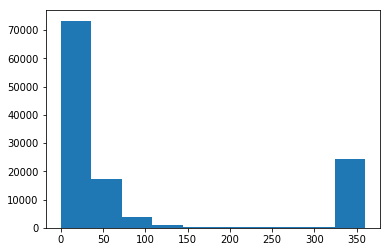

In [226]:
plt.hist(df.phi_range)

(array([5807., 7292., 4341., 3874., 3038., 2599., 2214., 2274., 2594.,
        2383., 2216., 2217., 2007., 1782., 1765., 2054., 1599., 1773.,
        1582., 1399., 1528., 1289., 1202., 1444., 1278., 1390., 1210.,
        1171., 1332., 1030.]),
 array([ 0.        ,  0.99955343,  1.99910685,  2.99866028,  3.9982137 ,
         4.99776713,  5.99732056,  6.99687398,  7.99642741,  8.99598083,
         9.99553426, 10.99508769, 11.99464111, 12.99419454, 13.99374797,
        14.99330139, 15.99285482, 16.99240824, 17.99196167, 18.9915151 ,
        19.99106852, 20.99062195, 21.99017537, 22.9897288 , 23.98928223,
        24.98883565, 25.98838908, 26.9879425 , 27.98749593, 28.98704936,
        29.98660278]),
 <a list of 30 Patch objects>)

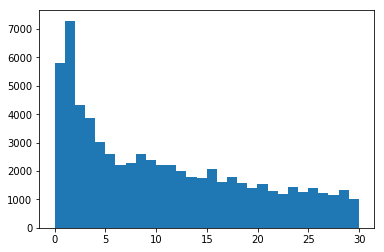

In [230]:
plt.hist(df[df.phi_range < 30].phi_range,bins=30)

(array([1.4916e+04, 8.6800e+03, 6.0300e+03, 5.6870e+03, 5.5410e+03,
        4.4010e+03, 4.5660e+03, 3.7740e+03, 3.5950e+03, 3.0830e+03,
        3.1430e+03, 3.1060e+03, 2.4320e+03, 2.3200e+03, 2.0560e+03,
        1.8160e+03, 1.6330e+03, 1.3800e+03, 1.7180e+03, 1.1960e+03,
        1.1420e+03, 1.3170e+03, 9.9500e+02, 1.0480e+03, 1.1270e+03,
        1.0000e+03, 7.8000e+02, 8.3900e+02, 6.2200e+02, 6.3200e+02,
        5.2900e+02, 4.2800e+02, 3.3200e+02, 3.3400e+02, 3.0000e+02,
        1.8000e+02, 2.4900e+02, 2.1400e+02, 2.6000e+02, 2.0200e+02,
        1.5500e+02, 1.1200e+02, 1.0700e+02, 9.5000e+01, 1.7600e+02,
        8.0000e+01, 1.0000e+02, 1.7000e+01, 5.6000e+01, 4.4000e+01,
        6.8000e+01, 6.2000e+01, 9.3000e+01, 1.0000e+01, 5.9000e+01,
        6.5000e+01, 2.1000e+01, 1.2300e+02, 5.5000e+01, 5.8000e+01,
        8.1000e+01, 1.5000e+01, 5.1000e+01, 2.8000e+01, 2.7000e+01,
        8.0000e+00, 3.8000e+01, 3.2000e+01, 4.2000e+01, 7.0000e+00,
        3.2000e+01, 1.1000e+01, 6.0000e+00, 2.80

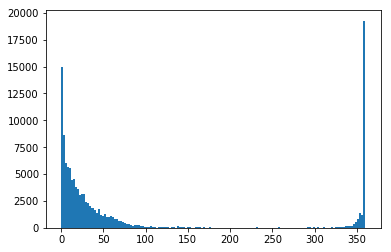

In [231]:
plt.hist(df.phi_range,bins=150)

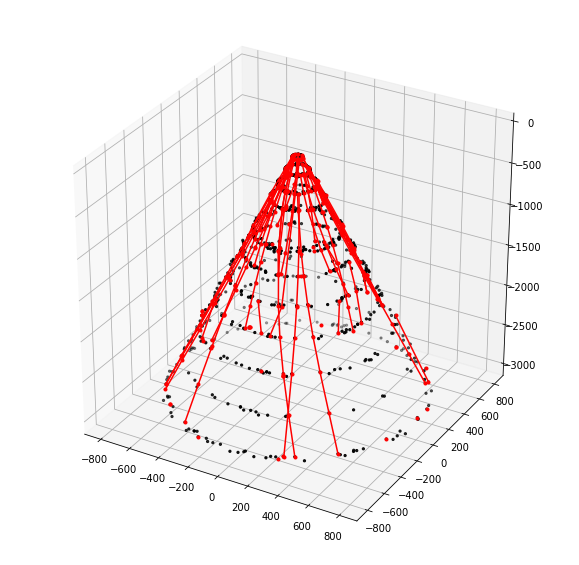

In [224]:
df = hits
df = df.assign(d =np.sqrt(df.x**2 + df.y**2 + df.z**2))
df = df.assign(r = np.sqrt(df.x**2 + df.y ** 2))
df = df.assign(arctan2 = np.arctan2(df.z, df.r))
df = df.assign(arctan2_deg = np.degrees(np.arctan2(df.z, df.r)))

df = df.loc[(df.arctan2_deg > -75-0.5) & (df.arctan2_deg < -75+0.5)]
particles_list = list(set(df.particle_id.values))
part = np.random.choice(particles_list, 100)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['x'], df['y'], df['z'], marker='.', color=[0,0,0])
for p in part:
    df1 = df[df.particle_id == p]
    ax.plot(df1['x'], df1['y'], df1['z'], marker='.', color=[1,0,0])
plt.show()

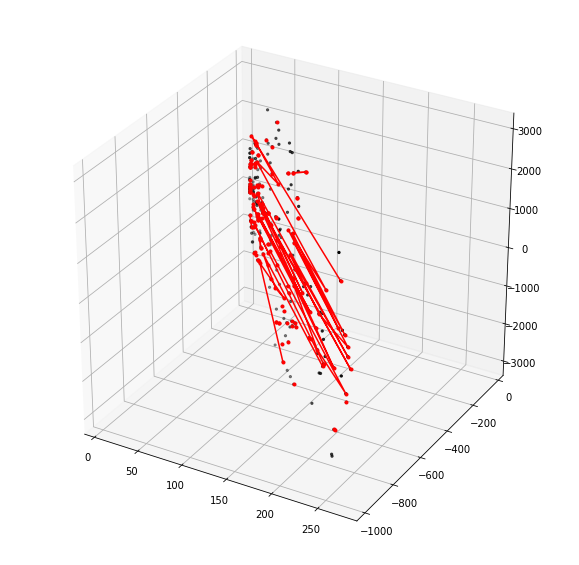

In [345]:
df = hits
df = df.assign(d =np.sqrt(df.x**2 + df.y**2 + df.z**2))
df = df.assign(r = np.sqrt(df.x**2 + df.y ** 2))
df = df.assign(arctan2 = np.arctan2(df.z, df.r))
df = df.assign(arctan2_deg = np.degrees(np.arctan2(df.z, df.r)))

df = df.loc[(df.phi_deg > -75-0.5) & (df.phi_deg < -75+0.5)]
particles_list = list(set(df.particle_id.values))
part = np.random.choice(particles_list, 100)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['x'], df['y'], df['z'], marker='.', color=[0,0,0])
for p in part:
    df1 = df[df.particle_id == p]
    ax.plot(df1['x'], df1['y'], df1['z'], marker='.', color=[1,0,0])
plt.show()

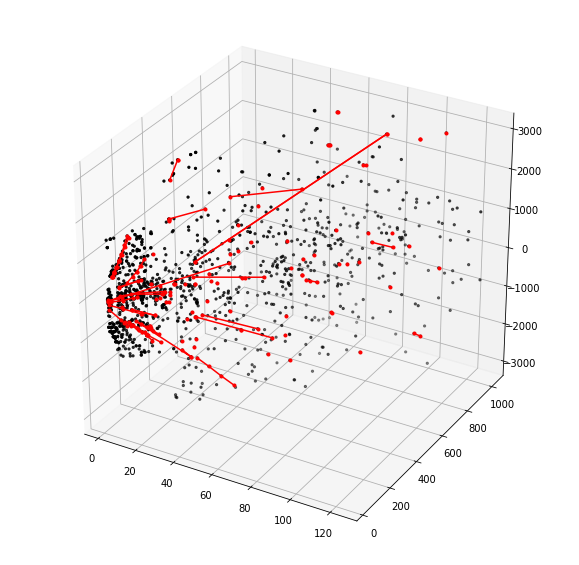

In [609]:
df = hits
df = df.assign(d =np.sqrt(df.x**2 + df.y**2 + df.z**2))
df = df.assign(r = np.sqrt(df.x**2 + df.y ** 2))
df = df.assign(arctan2 = np.arctan2(df.z, df.r))
df = df.assign(arctan2_deg = np.degrees(np.arctan2(df.z, df.r)))

df = df.loc[(df.phi_deg > 85-2) & (df.phi_deg < 85+2)]
particles_list = list(set(df.particle_id.values))
part = np.random.choice(particles_list, 100)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['x'], df['y'], df['z'], marker='.', color=[0,0,0])
for p in part:
    df1 = df[df.particle_id == p]
    ax.plot(df1['x'], df1['y'], df1['z'], marker='.', color=[1,0,0])
plt.show()

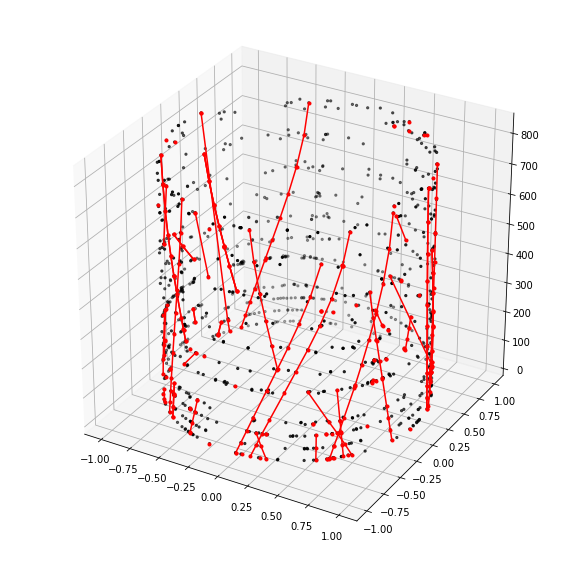

In [467]:
df = hits
df = df.assign(d =np.sqrt(df.x**2 + df.y**2 + df.z**2))
df = df.assign(r = np.sqrt(df.x**2 + df.y ** 2))
df = df.assign(at2 = np.arctan2(df.z,df.r))
df = df.assign(ac2 = np.arccos(df.z/df.r))
df = df.assign(at2_deg = np.degrees(np.arctan2(df.z, df.r)))

df = df.loc[(df.at2_deg > 75-0.5) & (df.at2_deg < 75+0.5)]
c = np.cos(df['phi'])
s = np.sin(df['phi'])
r = df['r'].values
particles_list = list(set(df.particle_id.values))
part = np.random.choice(particles_list, 100)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(c, s, r, marker='.', color=[0,0,0])
for p in part:
    df1 = df[df.particle_id == p]
    c = np.cos(df1['phi'])
    s = np.sin(df1['phi'])
    r = df1['r'].values
    ax.plot(c, s, r, marker='.', color=[1,0,0])
plt.show()

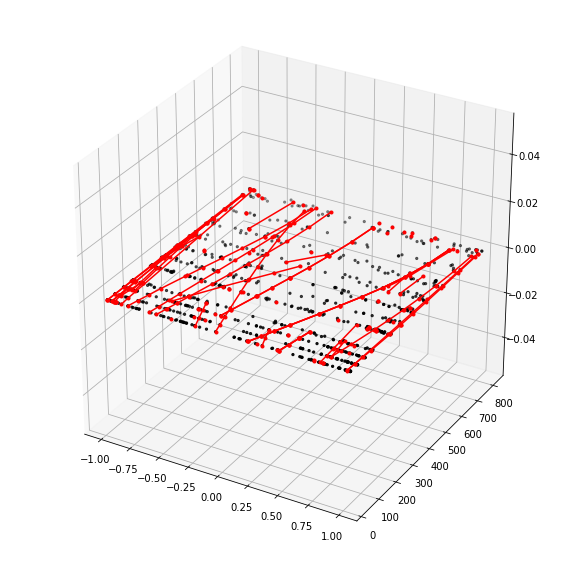

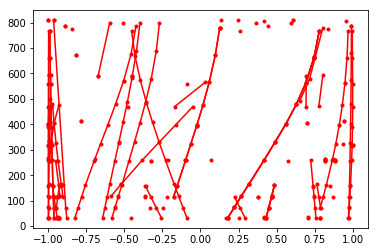

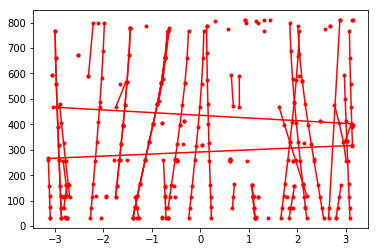

In [668]:
df = hits[hits.particle_id != 0]
df = df.assign(d =np.sqrt(df.x**2 + df.y**2 + df.z**2))
df = df.assign(r = np.sqrt(df.x**2 + df.y ** 2))
df = df.assign(at2 = np.arctan2(df.z,df.r))
df = df.assign(ac2 = np.arccos(df.z/df.r))
df = df.assign(at2_deg = np.degrees(np.arctan2(df.z, df.r)))

df = df.loc[(df.at2_deg > 75-0.5) & (df.at2_deg < 75+0.5)]
c = np.cos(df['phi'])
s = np.sin(df['phi'])
r = df['r'].values
particles_list = list(set(df.particle_id.values))
part = np.random.choice(particles_list, 100)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(c, r, marker='.', color=[0,0,0])
for p in part:
    df1 = df[df.particle_id == p]
    c = np.cos(df1['phi'])
    s = np.sin(df1['phi'])
    r = df1['r'].values
    ax.plot(c, r, marker='.', color=[1,0,0])
plt.show()


plt.scatter(c, r, marker='.', color=[0,0,0])
for p in part:
    df1 = df[df.particle_id == p]
    c = np.cos(df1['phi'])
    s = np.sin(df1['phi'])
    r = df1['r'].values
    plt.plot(c, r, marker='.', color=[1,0,0])
plt.show()

for p in part:
    df1 = df[df.particle_id == p]
    phi = df1['phi'].values
    c = np.cos(df1['phi'])
    s = np.sin(df1['phi'])
    r = df1['r'].values
    plt.plot(phi, r, marker='.', color=[1,0,0])
plt.show()

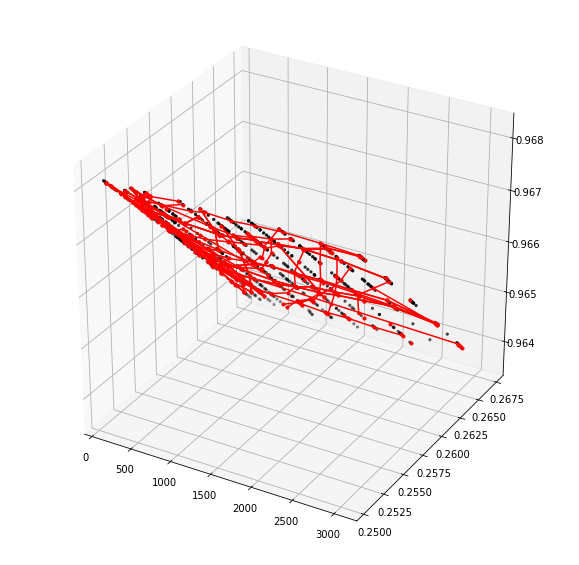

In [669]:
df = hits[hits.particle_id != 0]
df = df.assign(d =np.sqrt(df.x**2 + df.y**2 + df.z**2))
df = df.assign(r = np.sqrt(df.x**2 + df.y ** 2))
df = df.assign(at2 = np.arctan2(df.z,df.r))
df = df.assign(ac2 = np.arccos(df.z/df.r))
df = df.assign(at2_deg = np.degrees(np.arctan2(df.z, df.r)))

df = df.loc[(df.at2_deg > 75-0.5) & (df.at2_deg < 75+0.5)]
c = np.cos(df['theta'])
s = np.sin(df['theta'])
r = df['d'].values
particles_list = list(set(df.particle_id.values))
part = np.random.choice(particles_list, 100)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(r, s, c, marker='.', color=[0,0,0])
for p in part:
    df1 = df[df.particle_id == p]
    c = np.cos(df1['theta'])
    s = np.sin(df1['theta'])
    r = df1['d'].values
    ax.plot(r, s, c, marker='.', color=[1,0,0])
plt.show()

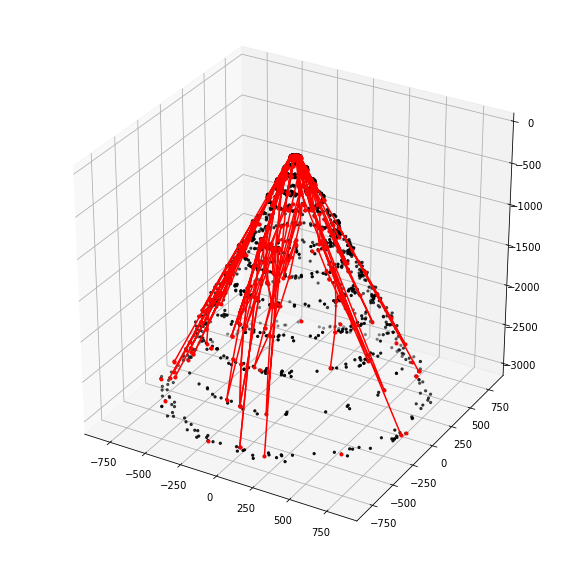

In [670]:
df = hits[hits.particle_id != 0]
df = df.assign(d =np.sqrt(df.x**2 + df.y**2 + df.z**2))
df = df.assign(r = np.sqrt(df.x**2 + df.y ** 2))
df = df.assign(arctan2 = np.arctan2(df.z, df.r))
df = df.assign(arctan2_deg = np.degrees(np.arctan2(df.z, df.r)))

df = df.loc[(df.arctan2_deg > -75-1) & (df.arctan2_deg < -75+1)]
particles_list = list(set(df.particle_id.values))
part = np.random.choice(particles_list, 100)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['x'], df['y'], df['z'], marker='.', color=[0,0,0])
for p in part:
    df1 = df[df.particle_id == p]
    ax.plot(df1['x'], df1['y'], df1['z'], marker='.', color=[1,0,0])
plt.show()

In [232]:
df = hits
df.sort_values(['particle_id', 'z'], inplace=True)
p_list = df.particle_id.unique()
for p in p_list:
    df1 = df[df.particle_id == p]
    phi_deg_range = np.max(df1.phi_deg) - np.min(df1.phi_deg)
    hits.loc[df.particle_id == p, 'phi_range'] = phi_deg_range
    

In [244]:
hits2 = hits
hits3 = pd.DataFrame()
tot = 0
i = 0
for phi_range in np.linspace(0.5,30,40):
    df = hits2
    df = df.assign(d =np.sqrt(df.x**2 + df.y**2 + df.z**2))
    df = df.assign(r = np.sqrt(df.x**2 + df.y ** 2))
    df = df.assign(arctan2 = np.arctan2(df.z, df.r))
    df = df.assign(arctan2_deg = np.degrees(np.arctan2(df.z, df.r)))
#     df = df.loc[(df.phi_deg > angle-0.5) & (df.phi_deg < angle+0.5)]
    df = df.loc[df.phi_range <= phi_range]
    particles_list = list(set(df.particle_id.values))
    if len(particles_list) <= 0:
        continue
    print()
    dbscan = DBSCAN(eps=0.0038, min_samples=1,metric='manhattan',n_jobs=8)
        
    labels = dbscan.fit_predict(scl.fit_transform(df[['r2', 'theta_1', 'dip_angle', 'z2', 'z2_1', 'z2_2']].values))

    labels += (i * 10000)
    i += 1
    df['track_id'] = labels
    score = score_event(df, df[['event_id','hit_id','track_id']])
    print(phi_range, len(particles_list), len(df), len(df['track_id'].unique()), score)
    scores.append([score, m])
    tot += len(df)
    hit_ids = df.hit_id.values
    hits2 = hits2[~hits2.hit_id.isin(hit_ids)]
    hits3 = hits3.append(df)
print(tot)
hits3.sort_values('hit_id', inplace=True)
print(score_event(hits3, hits3[['event_id','hit_id','track_id']]))
print(hits.shape, hits3.shape)


0.5 907 2307 965 0.9433779215781539

1.2564102564102564 496 5404 825 0.7826528177385096

2.0128205128205128 503 5437 854 0.6074366338049964

2.769230769230769 327 3298 791 0.5687002878883944

3.5256410256410255 319 3263 906 0.48917723127530816

4.282051282051282 265 2603 820 0.42594043819449373

5.038461538461538 234 2241 953 0.2908664579946857

5.794871794871795 192 1872 783 0.31999160508237123

6.551282051282051 185 1836 934 0.18905043642176295

7.3076923076923075 155 1594 767 0.24658970763476284

8.064102564102564 172 1805 959 0.18989821896961534

8.820512820512821 188 1929 1202 0.11291551977220432

9.576923076923077 163 1724 1032 0.1281235825674129

10.333333333333332 170 1886 1035 0.1595462617061845

11.08974358974359 155 1658 956 0.15666304854945023

11.846153846153847 151 1581 1023 0.1048060692620708

12.602564102564102 159 1669 1069 0.10983828266053547

13.358974358974358 115 1282 901 0.04118188305378766

14.115384615384615 131 1412 1005 0.06786910791242406

14.871794871794872

In [309]:
def extend_my(submission,hits):
#     df = submission.merge(hits,  on=['hit_id'], how='left')
    df = submission.append(hits)
    df = df.assign(d = np.sqrt( df.x**2 + df.y**2 + df.z**2 ))
    df = df.assign(r = np.sqrt( df.x**2 + df.y**2))
    df = df.assign(arctan2 = np.arctan2(df.z, df.r))

    for angle in range(-180,180,1):

        print ('\r %f'%angle, end='',flush=True)
        #df1 = df.loc[(df.arctan2>(angle-0.5)/180*np.pi) & (df.arctan2<(angle+0.5)/180*np.pi)]
        df1 = df.loc[(df.arctan2>(angle-1.0)/180*np.pi) & (df.arctan2<(angle+1.0)/180*np.pi)]

        min_num_neighbours = len(df1)
        if min_num_neighbours<4: continue

        hit_ids = df1.hit_id.values
        x,y,z = df1.as_matrix(columns=['x', 'y', 'z']).T
        r  = (x**2 + y**2)**0.5
        r  = r/1000
        a  = np.arctan2(y,x)
        tree = KDTree(np.column_stack([a,r]), metric='euclidean')

        track_ids = list(df1.track_id.unique())
        num_track_ids = len(track_ids)
        min_length=3
        print(num_track_ids)
        for i in range(num_track_ids):
            p = track_ids[i]
            if p==0: continue

            idx = np.where(df1.track_id==p)[0]
            if len(idx)<min_length: continue

            
            if angle>0:
                idx = idx[np.argsort( z[idx])]
            else:
                idx = idx[np.argsort(-z[idx])]


            print(idx, angle, p)
            ## start and end points  ##
            idx0,idx1 = idx[0],idx[-1]
            a0 = a[idx0]
            a1 = a[idx1]
            r0 = r[idx0]
            r1 = r[idx1]

            da0 = a[idx[1]] - a[idx[0]]  #direction
            dr0 = r[idx[1]] - r[idx[0]]
            direction0 = np.arctan2(dr0,da0) 

            da1 = a[idx[-1]] - a[idx[-2]]
            dr1 = r[idx[-1]] - r[idx[-2]]
            direction1 = np.arctan2(dr1,da1) 


            ## extend start point
            ns = tree.query([[a0,r0]], k=min(20,min_num_neighbours), return_distance=False)
            ns = np.concatenate(ns)
            direction = np.arctan2(r0-r[ns],a0-a[ns])
            ns = ns[(r0-r[ns]>0.01) &(np.fabs(direction-direction0)<0.04)]
            print(ns)
            for n in ns:
                df.loc[ df.hit_id==hit_ids[n],'track_id' ] = p 

            ## extend end point
            ns = tree.query([[a1,r1]], k=min(20,min_num_neighbours), return_distance=False)
            ns = np.concatenate(ns)

            direction = np.arctan2(r[ns]-r1,a[ns]-a1)
            ns = ns[(r[ns]-r1>0.01) &(np.fabs(direction-direction1)<0.04)] 
            print(ns)
            print('=======================================')
            for n in ns:
                df.loc[ df.hit_id==hit_ids[n],'track_id' ] = p
#print ('\r')
    df = df[['particle_id', 'weight', 'event_id', 'hit_id', 'track_id']]
    return df

In [305]:
hits2 = hits
hits3 = pd.DataFrame()
hits4 = pd.DataFrame()
hist1 = pd.DataFrame()
tot = 0
i = 0
for angle in range(-180, 180, 1):
    if i > 1:
        break
    df = hits2
    df = df.assign(d =np.sqrt(df.x**2 + df.y**2 + df.z**2))
    df = df.assign(r = np.sqrt(df.x**2 + df.y ** 2))
    df = df.assign(arctan2 = np.arctan2(df.z, df.r))
    df = df.assign(arctan2_deg = np.degrees(np.arctan2(df.z, df.r)))
    df = df.loc[(df.phi_deg > angle-1) & (df.phi_deg < angle+1)]
    particles_list = list(set(df.particle_id.values))
    if len(particles_list) <= 0:
        continue
    
    print()
    dbscan = DBSCAN(eps=0.0038, min_samples=1,metric='manhattan',n_jobs=8)
        
    labels = dbscan.fit_predict(scl.fit_transform(df[['r2', 'theta_1', 'dip_angle', 'z2', 'z2_1', 'z2_2']].values))

    labels += (i * 10000)
    i += 1
    df['track_id'] = labels
    score = score_event(df, df[['event_id','hit_id','track_id']])
    print(angle, len(particles_list), len(df), len(df['track_id'].unique()), score)
    scores.append([score, m])
    tot += len(df)
    hit_ids = df.hit_id.values
    hits2 = hits2[~hits2.hit_id.isin(hit_ids)]
    hits4 = hits4.append(df)
    if i > 1:
        hits3 = extend_my(hits3, df)
    else:
        hits3 = hits3.append(df)
        hits1 = df
print(tot)
hits3.sort_values('hit_id', inplace=True)
hits4.sort_values('hit_id', inplace=True)
print(score_event(hits3, hits3[['event_id','hit_id','track_id']]))
print(hits.shape, hits3.shape, hits4.shape)


-180 213 488 291 0.7107412833150375

-179 187 314 243 0.6759710601244779
 -88.0000000[4 3 2 1] -88 72
[]
[]
[7 6 5] -88 82
[]
[]
[10  9  8] -88 142
[]
[]
[14 13 12 11] -88 225
[]
[]
[21 20 19 18 17 16 15] -88 288
[]
[]
[29 28 27 26 25 24] -88 10241
[]
[]
 -87.000000[5 4 3 2] -87 72
[]
[]
[8 7 6] -87 82
[]
[]
[13 12 11] -87 142
[]
[]
[16 15 14] -87 144
[]
[]
[20 19 18 17] -87 225
[]
[]
[27 26 25 24 23 22 21] -87 288
[]
[]
[42 41 40 39 38 37] -87 10241
[]
[]
 -86.000000[7 6 5] -86 144
[]
[]
[12 11 10] -86 256
[]
[]
[24 23 22] -86 10211
[]
[]
 -85.000000[4 2 3] -85 126
[]
[]
[11 10  9] -85 256
[]
[]
[14 13 12] -85 10131
[]
[]
[21 20 19] -85 10211
[]
[]
 -84.000000[2 1 0] -84 113
[10]
[]
[6 3 5] -84 126
[]
[]
[14 13 12] -84 10131
[]
[]
 -83.000000[9 2 1 0] -83 113
[]
[]
[14 13 12] -83 10182
[]
[7 6]
 -82.000000[13 12 11  7  6] -82 10182
[]
[]
 -80.000000[23 22 21] -80 10218
[]
[]
 -79.000000[5 4 3 2 1] -79 93
[7]
[]
[20 19 18] -79 10218
[]
[]
 -78.000000[4 3 2 1 0] -78 93
[]
[]
[6 8 7] -7

In [276]:
hits3.shape

(802, 3)

In [277]:
df.shape

(314, 46)

In [458]:
ss = StandardScaler()
    
hits2 = hits
hits3 = pd.DataFrame()
hits4 = pd.DataFrame()
hist1 = pd.DataFrame()
tot = 0
i = 0
# for angle in [75, 80]:
#     if i > 2:
#         break
df = hits2
df = df.assign(d =np.sqrt(df.x**2 + df.y**2 + df.z**2))
df = df.assign(r = np.sqrt(df.x**2 + df.y ** 2))
df = df.assign(a2 = np.arctan2(df.z, df.r))
df = df.assign(a2_deg = np.degrees(np.arctan2(df.z, df.r)))
#     df = df.loc[(df.arctan2_deg > angle-1) & (df.arctan2_deg < angle+1)]
df = df.loc[(df.a2_deg > 75-0.5) & (df.a2_deg < 75+0.5)]
particles_list = list(set(df.particle_id.values))
# if len(particles_list) <= 0:
#     continue
phi = df['phi'].values
df['my_xx'] = df['d'].values
df['my_yy'] = df['phi'].values
df['my_zz'] = 1/df['a2'].values
my_z2 = df['z2'].values
df['z2_1'] = 1/z2
df['z2_2'] = phi/z2 + 1/z2

df['z1'] = df['z']/df['r'] 
df['a1'] = df['a2']+(0.000012*df['z']*np.sign(df['z'].values))
df['b1'] = df['a1']/df['z1']
df['b2'] = 1/df['z1']
df['b3'] = df['b1']+df['b2']
            
print()
dbscan = DBSCAN(eps=0.035, min_samples=1,metric='euclidean', n_jobs=8)

labels = dbscan.fit_predict(ss.fit_transform(df[['my_xx', 'my_yy', 'my_zz']].values))+1

# labels += (i * 10000)
# i += 1
df['track_id'] = labels
score = score_event(df, df[['event_id','hit_id','track_id']])
print(angle, len(particles_list), len(df), len(df['track_id'].unique()), score)
scores.append([score, m])
tot += len(df)
hit_ids = df.hit_id.values
hits2 = hits2[~hits2.hit_id.isin(hit_ids)]
hits4 = hits4.append(df)
if i > 1:
    hits3 = extend_my(hits3, df)
else:
    hits3 = hits3.append(df)
    hits1 = df
print(tot)
hits3.sort_values('hit_id', inplace=True)
hits4.sort_values('hit_id', inplace=True)
print(score_event(hits3, hits3[['event_id','hit_id','track_id']]))
print(hits.shape, hits3.shape, hits4.shape)


80 251 1102 1008 0.1426154496931157
1102
0.14261543578449232
(120939, 42) (1102, 54) (1102, 54)


In [420]:
df.sort_values(['particle_id', 'hit_id'])[df.particle_id == 963774443425890304]

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight,vx,vy,vz,px,py,pz,q,nhits,rho,r,x2,y2,z2,r2,phi,phi_deg,phi2,phi2_deg,theta,theta_1,tan_dip,tan_dip1,z2_1,z2_2,dip_angle,event_id,phi_range,d,a2,a2_deg,z1,a1,b1,b2,b3,track_id
23852,23853,21.941099,-23.220600,119.223000,8,2,134,963774443425890304,21.951700,-23.211201,119.233002,0.253717,-0.252948,1.31042,0.000010,0.001063,0.00228,2.1829,0.238446,-0.266725,1.31088,-1.0,15.0,123.429062,31.946959,0.177763,-0.188129,3.731905,0.258828,-0.813722,-46.622841,-0.813722,-46.622845,0.261809,0.069245,-3.108073,-0.218045,0.267960,0.049915,1.514420,1000,28.283785,123.429062,1.308987,74.999435,3.731905,1.310418,0.351139,0.267960,0.619099,1053
23920,23921,23.514900,-24.765400,127.293999,8,2,135,963774443425890304,23.515301,-24.764400,127.293999,0.255437,-0.251895,1.31023,0.000009,0.001063,0.00228,2.1829,0.238446,-0.266725,1.31088,-1.0,15.0,131.795441,34.150780,0.178420,-0.187908,3.727411,0.259120,-0.811293,-46.483673,-0.811293,-46.483675,0.262111,0.069406,-3.095233,-0.217656,0.268283,0.050627,1.514457,1000,28.283785,131.795441,1.308686,74.982170,3.727411,1.310213,0.351508,0.268283,0.619790,1054
32155,32156,50.803001,-50.447899,264.779999,8,4,332,963774443425890304,50.797501,-50.453899,264.752014,0.267876,-0.237280,1.30971,0.000008,0.001063,0.00228,2.1829,0.238446,-0.266725,1.31088,-1.0,15.0,274.288879,71.595642,0.185217,-0.183923,3.698270,0.261023,-0.781891,-44.799053,-0.781891,-44.799056,0.264082,0.070463,-2.960794,-0.211421,0.270397,0.058976,1.515667,1000,28.283785,274.288879,1.306715,74.869240,3.698270,1.309892,0.354191,0.270397,0.624587,1055
32165,32166,52.252499,-51.739399,271.859009,8,4,333,963774443425890304,52.252800,-51.738899,271.856995,0.268331,-0.235881,1.30966,0.000007,0.001063,0.00228,2.1829,0.238446,-0.266725,1.31088,-1.0,15.0,281.628510,73.534271,0.185537,-0.183715,3.697038,0.261104,-0.780464,-44.717300,-0.780464,-44.717302,0.264165,0.070508,-2.954452,-0.211105,0.270487,0.059382,1.515732,1000,28.283785,281.628510,1.306631,74.864426,3.697038,1.309893,0.354309,0.270487,0.624796,1056
39750,39751,84.633400,-78.147797,425.769989,8,6,696,963774443425890304,84.631203,-78.150803,425.774994,0.283666,-0.215196,1.30934,0.000006,0.001063,0.00228,2.1829,0.238446,-0.266725,1.31088,-1.0,15.0,441.078186,115.195015,0.191878,-0.177174,3.696080,0.261167,-0.745577,-42.718399,-0.745577,-42.718402,0.264231,0.070543,-2.821687,-0.201721,0.270557,0.068836,1.518162,1000,28.283785,441.078186,1.306566,74.860687,3.696080,1.311675,0.354883,0.270557,0.625440,1057
47239,47240,123.666000,-105.778000,602.000000,9,2,43,963774443425890304,123.658997,-105.785004,602.000000,0.299424,-0.193495,1.30752,0.000005,0.001063,0.00228,2.1829,0.238446,-0.266725,1.31088,-1.0,15.0,623.607422,162.733719,0.198307,-0.169623,3.699295,0.260955,-0.707593,-40.542103,-0.707593,-40.542101,0.264012,0.070425,-2.680158,-0.191278,0.270322,0.079044,1.520923,1000,28.283785,623.607422,1.306785,74.873238,3.699295,1.314009,0.355205,0.270322,0.625527,1058
78049,78050,212.884995,-153.742004,973.440002,13,2,776,963774443425890304,212.871994,-153.753998,973.008972,0.325392,-0.145569,1.30598,0.000003,0.001063,0.00228,2.1829,0.238446,-0.266725,1.31088,-1.0,15.0,1008.237122,262.595947,0.211146,-0.152486,3.706988,0.260451,-0.625460,-35.836189,-0.625459,-35.836189,0.263489,0.070144,-2.373761,-0.168724,0.269761,0.101036,1.526880,1000,28.283785,1008.237122,1.307307,74.903198,3.706988,1.318989,0.355811,0.269761,0.625572,1060
78051,78052,206.940002,-151.061996,949.200012,13,2,777,963774443425890304,206.934998,-151.067993,949.184021,0.324688,-0.148747,1.30593,0.000004,0.001063,0.00228,2.1829,0.238446,-0.266725,1.31088,-1.0,15.0,983.170654,256.210632,0.210482,-0.153648,3.704764,0.260596,-0.630565,-36.128685,-0.630565,-36.128685,0.263640,0.070225,-2.391765,-0.170204,0.269923,0.099719,1.526471,1000,28.283785,983.170654,1.307157,74.894547,3.704764,1.318547,0.355906,0.269923,0.625829,1059
78229,78230,215.856003,-155.093002,984.760

In [500]:
path_to_train = "../data/train_100_events"
event_prefix = "event000001030"
hits, cells, particles, truth = load_event(os.path.join(path_to_train, event_prefix))
hits['event_id'] = 1030
truth = pd.merge(truth, particles, how='left', on='particle_id')
hits = pd.merge(hits, truth, how='left', on='hit_id')
hits = hits.fillna(0)

In [501]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,event_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight,vx,vy,vz,px,py,pz,q,nhits
0,1,-60.872200,-2.90994,-1502.5,7,2,1,1030,427858663433043968,-60.889999,-2.93122,-1502.5,-0.389865,-0.039903,-9.71788,0.000008,0.010579,-0.000096,-2.68331,-0.396593,-0.000155,-9.72165,-1.0,12.0
1,2,-68.620903,-6.93030,-1502.5,7,2,1,1030,923241222145835008,-68.614998,-6.94011,-1502.5,-0.225243,-0.003877,-4.86031,0.000008,0.012087,-0.023069,13.10000,-0.216069,-0.041984,-4.86522,1.0,13.0
2,3,-64.580200,2.66632,-1502.5,7,2,1,1030,4523734434054144,-64.563400,2.67475,-1502.5,-0.284755,-0.008789,-6.74716,0.000006,-0.009604,0.008012,-2.28776,-0.292098,0.031685,-6.75259,-1.0,16.0
3,4,-88.734299,-7.35970,-1502.5,7,2,1,1030,261225408500858880,-88.749001,-7.38212,-1502.5,-0.904795,-0.049219,-15.14960,0.000012,0.001303,0.017286,-8.23350,-0.894095,-0.099110,-15.15630,1.0,14.0
4,5,-88.326202,-13.04520,-1502.5,7,2,1,1030,743099023757410304,-88.316299,-13.05070,-1502.5,-0.295502,-0.016784,-4.90527,0.000006,-0.011714,-0.011290,-5.07843,-0.283424,-0.068196,-4.91150,1.0,16.0


In [502]:


x = hits.x.values
y = hits.y.values
z = hits.z.values

# truth['tpr'] = np.sqrt(truth.tpx ** 2 + truth.tpy ** 2)
# truth['p_phi_truth'] = np.arctan2(truth.tpy, truth.tpx)
# truth['p_theta_truth'] = np.arctan2(truth.tpr, truth.tpz)
    
hits['rho'] = np.sqrt(x**2 + y**2 + z**2)
hits['r'] = np.sqrt(x**2 + y**2)

hits['x2'] = hits['x']/hits['rho']
hits['y2'] = hits['y']/hits['rho']
hits['z2'] = hits['z']/hits['r']

x2 = hits.x2.values
y2 = hits.y2.values
z2 = hits.z2.values

hits['r2'] = np.sqrt(x2**2 + y2**2)
hits['phi'] = np.arctan2(hits['y'], hits['x'])
hits['phi_deg'] = np.degrees(np.arctan2(hits['y'], hits['x']))
hits['phi2'] = np.arctan2(hits['y2'], hits['x2'])
hits['phi2_deg'] = np.degrees(np.arctan2(hits['y2'], hits['x2']))

hits['theta'] = np.arctan2(hits['r'], hits['z'])
hits['theta_1'] = np.arctan2(hits['r2'], hits['z2'])


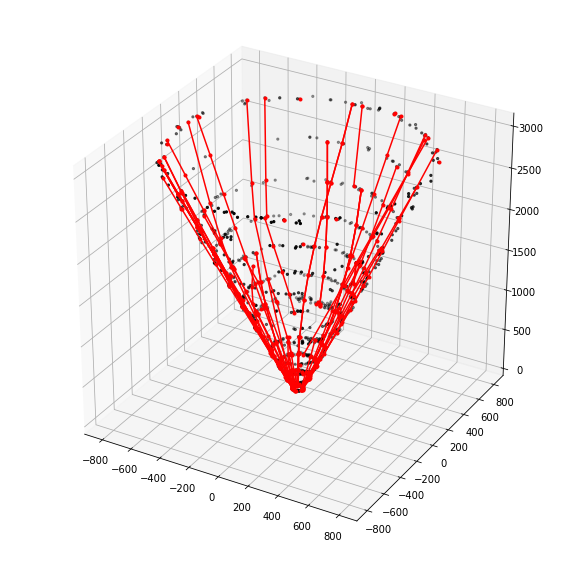

In [503]:
df = hits
df = df.assign(d =np.sqrt(df.x**2 + df.y**2 + df.z**2))
df = df.assign(r = np.sqrt(df.x**2 + df.y ** 2))
df = df.assign(arctan2 = np.arctan2(df.z, df.r))
df = df.assign(arctan2_deg = np.degrees(np.arctan2(df.z, df.r)))

df = df.loc[(df.arctan2_deg > 75-0.5) & (df.arctan2_deg < 75+0.5)]
particles_list = list(set(df.particle_id.values))
part = np.random.choice(particles_list, 100)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['x'], df['y'], df['z'], marker='.', color=[0,0,0])
for p in part:
    df1 = df[df.particle_id == p]
    ax.plot(df1['x'], df1['y'], df1['z'], marker='.', color=[1,0,0])
plt.show()

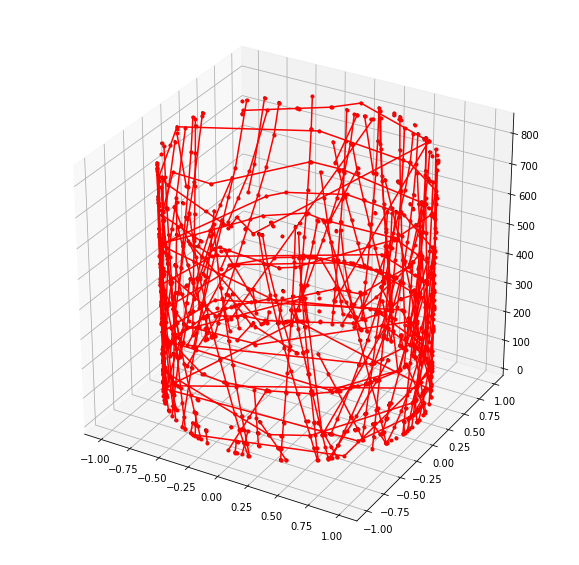

In [535]:
df = hits
df = df.assign(d =np.sqrt(df.x**2 + df.y**2 + df.z**2))
df = df.assign(r = np.sqrt(df.x**2 + df.y ** 2))
df = df.assign(a2 = np.arctan2(df.z, df.r))
df = df.assign(a2_deg = np.degrees(np.arctan2(df.z, df.r)))

df = df.loc[(df.a2_deg > 75-0.5) & (df.a2_deg < 75+0.5)]
particles_list = list(set(df.particle_id.values))
part = particles_list
# part = np.random.choice(particles_list, 100)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# r theta is plane
# r phi is a cylinder
# rho phi is a cylinder, d-phi is also a cylinder
# rho theta is a plane (same as r theta)
# d theta is a plane same as rho theta
# r a2 is a plane same as s theta
# rho a2 is a plane
# d a2 is a plane
# d 1/a2 is a plane
r = df['r'].values
angle = df['phi'].values 

c = np.cos(angle)
s = np.sin(angle)
r = r
ax.scatter(c, s, r, marker='.', color=[0,0,0])
for p in part:
    df1 = df[df.particle_id == p]
    r1 = df1['r'].values
    angle1 = df1['phi'].values 

    c1 = np.cos(angle1)
    s1 = np.sin(angle1)
    r1 = r1
    ax.plot(c1,s1,r1, marker='.', color=[1,0,0])
plt.show()

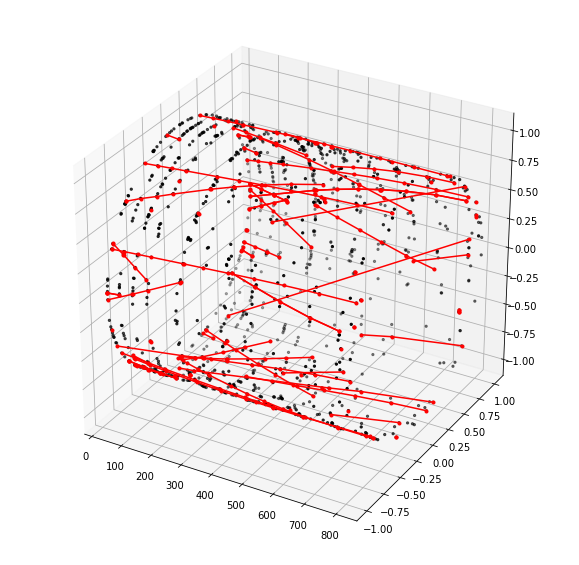

In [576]:
df = hits
df = df.assign(d =np.sqrt(df.x**2 + df.y**2 + df.z**2))
df = df.assign(r = np.sqrt(df.x**2 + df.y ** 2))
df = df.assign(a2 = np.arctan2(df.z, df.r))
df = df.assign(a2_deg = np.degrees(np.arctan2(df.z, df.r)))

df = df.loc[(df.a2_deg > 75-0.5) & (df.a2_deg < 75+0.5)]
particles_list = list(set(df.particle_id.values))
part = np.random.choice(particles_list, 100)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# r theta is plane
# r phi is a cylinder
# rho phi is a cylinder, d-phi is also a cylinder
# rho theta is a plane (same as r theta)
# d theta is a plane same as rho theta
# r a2 is a plane same as s theta
# rho a2 is a plane
# d a2 is a plane
# d 1/a2 is a plane
r = df['r'].values
angle = df['phi'].values 

c = np.cos(angle)
s = np.sin(angle)
r = r
ax.scatter(r, s, c, marker='.', color=[0,0,0])
for p in part:
    df1 = df[df.particle_id == p]
    r1 = df1['r'].values
    angle1 = df1['phi'].values 

    c1 = np.cos(angle1)
    s1 = np.sin(angle1)
    r1 = r1
    ax.plot(r1, s1, c1, marker='.', color=[1,0,0])
plt.show()

In [518]:
ss = StandardScaler()
    
hits2 = hits
hits3 = pd.DataFrame()
hits4 = pd.DataFrame()
hist1 = pd.DataFrame()
tot = 0
i = 0
# for angle in [75, 80]:
#     if i > 2:
#         break
df = hits2
df = df.assign(d =np.sqrt(df.x**2 + df.y**2 + df.z**2))
df = df.assign(r = np.sqrt(df.x**2 + df.y ** 2))
df = df.assign(a2 = np.arctan2(df.z, df.r))
df = df.assign(a2_deg = np.degrees(np.arctan2(df.z, df.r)))
#     df = df.loc[(df.arctan2_deg > angle-1) & (df.arctan2_deg < angle+1)]
df = df.loc[(df.a2_deg > 75-0.5) & (df.a2_deg < 75+0.5)]
particles_list = list(set(df.particle_id.values))
# if len(particles_list) <= 0:
#     continue
r = df['r'].values
phi = df['phi'].values
df['my_zz'] = r
df['my_xx'] = np.cos(df['phi'])
df['my_yy'] = np.sin(df['phi'])

df['my_rho2'] = np.sqrt(df['my_xx']**2 + df['my_yy']**2 + df['my_zz']**2)
df['my_x2'] = df['my_xx']/df['my_rho2']
df['my_y2'] = df['my_yy']/df['my_rho2']
df['my_z2'] = df['my_zz']/df['my_rho2']
# my_z2 = df['z2'].values
# df['z2_1'] = 1/z2
# df['z2_2'] = phi/z2 + 1/z2

# df['z1'] = df['z']/df['r'] 
# df['a1'] = df['a2']+(0.000012*df['z']*np.sign(df['z'].values))
# df['b1'] = df['a1']/df['z1']
# df['b2'] = 1/df['z1']
# df['b3'] = df['b1']+df['b2']

dbscan = DBSCAN(eps=0.00095, min_samples=1,metric='euclidean', n_jobs=8)

labels = dbscan.fit_predict(ss.fit_transform(df[['my_x2', 'my_y2', 'my_z2']].values))

# labels += (i * 10000)
# i += 1
df['track_id'] = labels
score = score_event(df, df[['event_id','hit_id','track_id']])
print(angle, len(particles_list), len(df), len(df['track_id'].unique()), score)
scores.append([score, m])
tot += len(df)
hit_ids = df.hit_id.values
hits2 = hits2[~hits2.hit_id.isin(hit_ids)]
hits4 = hits4.append(df)
if i > 1:
    hits3 = extend_my(hits3, df)
else:
    hits3 = hits3.append(df)
    hits1 = df
print(tot)
hits3.sort_values('hit_id', inplace=True)
hits4.sort_values('hit_id', inplace=True)
print(score_event(hits3, hits3[['event_id','hit_id','track_id']]))
print(hits.shape, hits3.shape, hits4.shape)

[-3.0973594 -3.0636644 -2.7411473 ...  2.936433   2.962709   3.0494452] 280 1310 1270 0.1142848574603847
1310
0.1142848574603847
(113998, 36) (1310, 47) (1310, 47)


In [506]:
hits.head().T

,0,1,2,3,4
hit_id,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00
x,-6.087220e+01,-6.862090e+01,-6.458020e+01,-8.873430e+01,-8.832620e+01
y,-2.909940e+00,-6.930300e+00,2.666320e+00,-7.359700e+00,-1.304520e+01
z,-1.502500e+03,-1.502500e+03,-1.502500e+03,-1.502500e+03,-1.502500e+03
volume_id,7.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00
layer_id,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00
module_id,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
event_id,1.030000e+03,1.030000e+03,1.030000e+03,1.030000e+03,1.030000e+03
particle_id,4.278587e+17,9.232412e+17,4.523734e+15,2.612254e+17,7.430990e+17
tx,-6.089000e+01,-6.861500e+01,-6.456340e+01,-8.874900e+01,-8.831630e+01


In [575]:
ss = StandardScaler()
    
hits2 = hits
hits3 = pd.DataFrame()
hits4 = pd.DataFrame()
hist1 = pd.DataFrame()
tot = 0
i = 0

df = hits2
df = df.assign(d =np.sqrt(df.x**2 + df.y**2 + df.z**2))
df = df.assign(r = np.sqrt(df.x**2 + df.y ** 2))
df = df.assign(a = np.arctan2(df.y, df.x))
df = df.assign(a2 = np.arctan2(df.z, df.r))
df = df.assign(a2_deg = np.degrees(np.arctan2(df.z, df.r)))

# for angle in [75, 80]:
#     if i > 2:
#         break
# r  = np.sqrt(x**2+y**2)
# d  = np.sqrt(x**2+y**2+z**2)
# a  = np.arctan2(y,x)
rr = r/1000

# hits=[x, y, z, np.sin(a), np.cos(a), d, r, z/r, z/d, r/d,  ]
# for i in np.arange(-100,100,1):
#     aa = a + (rr+0.05*rr**2)*i/180*np.pi
#     hits.append(np.sin(aa))
#     hits.append(np.cos(aa))


#     df = df.loc[(df.arctan2_deg > angle-1) & (df.arctan2_deg < angle+1)]
df = df.loc[(df.a2_deg > 75-0.5) & (df.a2_deg < 75+0.5)]
particles_list = list(set(df.particle_id.values))
# if len(particles_list) <= 0:
#     continue
# z = df['r'].values
# x = np.cos(df['phi'])
# y = np.sin(df['phi'])
x = df['x'].values
y = df['y'].values
z = df['z'].values

x2 = df['x2'].values
y2 = df['y2'].values
z2 = df['z2'].values

df['r'] = np.sqrt(x**2 + y**2)
df['d'] = np.sqrt(x**2 + y**2 + z**2)
df['a'] = np.arctan2(y,x)
df['c']  = np.cos(df['a'].values)
df['s'] = np.sin(df['a'].values)

df['z_r'] = df['z']/df['r']
df['z_d'] = df['z']/df['d']
df['r_d'] = df['r']/df['d']

df['r2'] = np.sqrt(x2**2 + y2**2)
df['d2'] = np.sqrt(x2**2 + y2**2 + z2**2)
df['a2'] = np.arctan2(y2,x2)
df['c2']  = np.cos(df['a2'].values)
df['s2'] = np.sin(df['a2'].values)

df['z2_r'] = df['z2']/df['r2']
df['z2_d'] = df['z2']/df['d2']
df['r2_d'] = df['r2']/df['d2']

a = df['a'].values
r = df['r'].values
d = df['d'].values

# dz = dz + ( i*0.00001)
# aa = a + np.sign(z)*dz*z
# zr = df['my_z']/df['my_r']
# dr = d/r
# f1 = zr

# df['my_x2'] = df['d']/df['my_rho2']
# df['my_y2'] = df['phi']/df['my_rho2']

# x  = df.x.values
# y  = df.y.values
# z  = df.z.values
# r  = np.sqrt(x**2+y**2)
# d  = np.sqrt(x**2+y**2+z**2)
# a  = np.arctan2(y,x)
# zr = z/r
# dr = d/r
# f0 = aa
# f1 = zr
# f2 = aa/zr
# f3 =  1/zr
# f4 = f2 + f3
# my_z2 = df['z2'].values
# df['z2_1'] = 1/z2
# df['z2_2'] = phi/z2 + 1/z2

# df['z1'] = df['z']/df['r'] 
# df['a1'] = df['a2']+(0.000012*df['z']*np.sign(df['z'].values))
# df['b1'] = df['a1']/df['z1']
# df['b2'] = 1/df['z1']
# df['b3'] = df['b1']+df['b2']
j = 0
for i in np.arange(-100,100,1):
    aa = a + (rr+0.05*rr**2)*i/180*np.pi
    df['aa'] = aa
    df['saa'] = np.sin(aa)
    df['caa'] = np.cos(aa)
# 'z2', 'phi', 'rho', 'r', 'theta', 'tan_dip'
    dbscan = DBSCAN(eps=0.0075, min_samples=1,metric='manhattan', n_jobs=8)

# labels = dbscan.fit_predict(ss.fit_transform(df[['my_x2', 'my_y2', 'my_z2']].values))
    labels = dbscan.fit_predict(ss.fit_transform(df[['aa','x', 'y', 'z', 'saa', 'caa', 'd', 'r', 'z_r', 'z_d', 'r_d']].values))
# labels = dbscan.fit_predict(ss.fit_transform(df[['x2', 'y2', 'z2', 's2', 'c2', 'd2', 'r2', 'z2_r', 'z2_d', 'r2_d']].values))

# labels += (i * 10000)
    j += 1
    df['track_id'] = labels
    score = score_event(df, df[['event_id','hit_id','track_id']])
    print(angle, len(particles_list), len(df), len(df['track_id'].unique()), score)
    scores.append([score, m])
    tot += len(df)
    hit_ids = df.hit_id.values
    hits2 = hits2[~hits2.hit_id.isin(hit_ids)]
    hits4 = hits4.append(df)
    if j > 1:
        hits3 = extend_my(hits3, df)
    else:
        hits3 = hits3.append(df)
        hits1 = df
    print(tot)
    hits3.sort_values('hit_id', inplace=True)
    hits4.sort_values('hit_id', inplace=True)
    print(score_event(hits3, hits3[['event_id','hit_id','track_id']]))
    print(hits.shape, hits3.shape, hits4.shape)

[-3.0973594 -3.0636644 -2.7411473 ...  2.936433   2.962709   3.0494452] 280 1310 1307 0.11225644913724468
1310
0.11225644913724468
(113998, 36) (1310, 55) (1310, 55)
[-3.0973594 -3.0636644 -2.7411473 ...  2.936433   2.962709   3.0494452] 280 1310 1307 0.11225644913724468
 74.00000000637
[306 308 944 946] 74 593
[]
[]
 75.0000001307
[ 411 1721  412 1722] 75 411
[]
[]
[ 594  597 1904 1907] 75 593
[]
[]
[ 624 1934  623 1933] 75 621
[]
[]
 76.000000670
[206 878 207 879] 76 411
[]
[]
[300 972 299 971] 76 621
[]
[]
 179.0000002620


MergeError: Merge keys are not unique in either left or right dataset; not a one-to-one merge

In [531]:
len(particles_list)

280

In [ ]:
# x,y,z = xyz.T
# r  = np.sqrt(x**2+y**2)
# d  = np.sqrt(x**2+y**2+z**2)
# a  = np.arctan2(y,x)
# rr = r/1000

# hits=[x, y, z, np.sin(a), np.cos(a), d, r, z/r, z/d, r/d,  ]
# for i in np.arange(-100,100,1):
#     aa = a + (rr+0.05*rr**2)*i/180*np.pi
#     hits.append(np.sin(aa))
#     hits.append(np.cos(aa))

# hits['r2'] = np.sqrt(x2**2 + y2**2)
# hits['phi'] = np.arctan2(hits['y'], hits['x'])
# hits['phi_deg'] = np.degrees(np.arctan2(hits['y'], hits['x']))
# hits['phi2'] = np.arctan2(hits['y2'], hits['x2'])
# hits['phi2_deg'] = np.degrees(np.arctan2(hits['y2'], hits['x2']))

# hits['theta'] = np.arctan2(hits['r'], hits['z'])
# hits['theta_1'] = np.arctan2(hits['r2'], hits['z2'])

# phi = hits['phi'].values
# theta = hits['theta'].values
# rho = hits['rho'].values
# r = hits['r'].values
# hits['tan_dip'] = phi/theta
# hits['tan_dip1'] = phi/z2
# hits['z2_1'] = 1/z2
# hits['z2_2'] = phi/z2 + 1/z2
# # hits['dip'] = np.degrees(np.arctan2(hits['phi'], hits['z2']))
# hits['dip_angle'] = np.arctan2(z2, (np.sqrt(x2**2 +y2**2)) * np.arccos(x2/np.sqrt(x2**2 + y2**2)))
# scores = []

In [677]:
hits2 = hits
hits3 = pd.DataFrame()
tot = 0
i = 0
for angle in range(-180, 180, 1):
    df = hits2
    df = df.assign(d =np.sqrt(df.x**2 + df.y**2 + df.z**2))
    df = df.assign(r = np.sqrt(df.x**2 + df.y ** 2))
    df = df.assign(arctan2 = np.arctan2(df.z, df.r))
    df = df.assign(phi = np.arctan2(df.y, df.x))
    df = df.assign(arctan2_deg = np.degrees(np.arctan2(df.z, df.r)))
    df = df.loc[(df.arctan2_deg > angle-0.5) & (df.arctan2_deg < angle+0.5)]
    
#     df['rx'] = np.cos(df['phi'].values)
    df['rx'] = df['phi'].values
    
#     df['ry'] = np.cos(df['phi'].values)
    df['ry'] = df['r'].values
    
    df['rr'] = np.sqrt(df['rx']**2 + df['ry']**2)
    
    df['rx2'] = df['rx']/df['rr']
    df['ry2'] = df['ry']/df['rr']
    df['phiphi'] = np.arctan2(df['ry'], df['rx'])
    particles_list = list(set(df.particle_id.values))
    if len(particles_list) <= 0:
        continue
    print()
    
   

#     X = scl.fit_transform(df[['rr', 'theta_1', 'dip_angle', 'z2', 'z2_1', 'z2_2']].values
#     X = scl.fit_transform(df[['rr', 'theta_1', 'dip_angle', 'z2', 'z2_1', 'z2_2']].values
    X = scl.fit_transform(df[['rx2', 'ry2', 'phiphi']].values)
    labels = DBSCAN(eps=0.0038, min_samples=1,metric='euclidean',n_jobs=8).fit(X).labels_

#     n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    
    labels += (i * 10000)
    i += 1
    df['track_id'] = labels
#     hits3 = hits3.append(df)
    
    score = score_event(df, df[['event_id','hit_id','track_id']])
    print(angle, len(particles_list), len(df), len(df['track_id'].unique()), score)
    
    scores.append([score, m])
    tot += len(df)
    hit_ids = df.hit_id.values
    hits2 = hits2[~hits2.hit_id.isin(hit_ids)]
    hits3 = hits3.append(df)
sub = hits3
# for i in range(8):
#     sub1 = extend(sub, hits3)
#     sub1 = sub1.drop_duplicates(keep='first')
#     sub['track_id'] = sub1.track_id.values
#     sub = sub.drop_duplicates(keep='first')
sub = sub.sort_values('hit_id')
print(tot)
hits3.sort_values('hit_id', inplace=True)
print(score_event(sub, hits3[['event_id','hit_id','track_id']]))
print(hits.shape, hits3.shape)




-89 2 6 5 0.45454513970680305

-88 175 1787 1566 0.004543494333837495

-87 334 4089 3533 0.0013552693138690589

-86 253 2606 2392 0.011264177287641888

-85 266 2338 2170 0.01964872064012874

-84 254 2166 2023 0.02157872442918172

-83 228 2021 1901 0.025465501338612157

-82 233 1676 1619 0.03222157884413255

-81 206 1497 1435 0.037118577566338226

-80 218 1466 1431 0.057243237426345656

-79 256 1435 1407 0.09032090106212196

-78 201 1207 1183 0.07153334269317346

-77 192 978 975 0.06902984520119977

-76 244 1051 1042 0.14220928239742361

-75 267 1143 1133 0.16476669919965498

-74 253 884 878 0.18790290305648058

-73 269 909 901 0.16621406530997518

-72 246 898 891 0.15790524513447404

-71 240 912 908 0.16362730959399044

-70 243 806 803 0.22710074707395453

-69 256 847 842 0.2068209239966886

-68 234 876 863 0.1265194793840944

-67 255 771 768 0.24815312032571835

-66 239 651 646 0.20794267667623753

-65 248 819 814 0.17266833670724047

-64 242 758 754 0.17483710625218057

-63 264 783 